# Modeling of degradation-induced leak in heterochiral translators

MIT License

Copyright (c) 2024-25 Lakin Lab

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Header: leave this code alone!!!

### Imports for data processing

In [1]:
import pandas as pd
import io
import requests
import sys
import os
import os.path # (generally useful!)

### Import numpy and matplotlib, extend default color cycle, and set some default plot style arguments

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from cycler import cycler

## These are matplotlib defaults (old and new)
#old_default_color_cycle_SEVEN = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
#new_default_color_cycle_TEN = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
#                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## My modified version of the default color cycle, especially for these plots
new_default_color_cycle_TEN_MODIFIED = ['#1f77b4', '#ff7f0e',
                                       #'#2ca02c', # Remove green one from default cycle; it is too similar to the lime I use for fluorescent data.
                                        '#9467bd', # Purple one from default cycle; swap default order with red
                                        '#d62728', # Red one from default cycle; swap order with purple
                                        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
## Here are ten more colors I picked to try and extend the default color cycle.
## Could add more here if necessary.
ext_default_color_cycle_TEN = ['#ffdd55', '#800080', '#ccff00', '#0000ff', '#ff5599',
                               '#333333', '#80ff80', '#ffb380', '#aaffee', '#ff5555']
mpl.rcParams['axes.prop_cycle'] = cycler(color=new_default_color_cycle_TEN_MODIFIED + ext_default_color_cycle_TEN)

## Some nice fonts
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 11

### Import some general stuff for timing jobs and loading / saving results etc

In [3]:
from timeit import default_timer as timer
import json
import textwrap

### Summarize a data frame

If you want to access the mean and standard deviation of values summarized via the function below, just pass the name of that condition to these functions. This ensures consistent naming throughout the code, which should prevent some errors.

In [4]:
def meanname(condition):
    return str(condition)+'_Mean'
def stdname(condition):
    return str(condition)+'_Std'

The following function "summarizes" a dataframe according to the groupings of indexes specified by the data info dictionaries (such as those above). We create a new dataframe with the same time index as the original dataset (they all should have the same time index). Then, loop over the tags and labels. We first check that we aren't overwriting any existing data, which would only happen if we duplicated a tag above. Then we add certain aggregated statistics columns for each tag. We get these by selecting just the specified labels from the original dataframe and calling appropriate methods on them. By setting `axis=1` we ensure that the aggregate is computed pointwise for each timepoint, rather than across each row separately. The `statsToCompute` optional argument specifies what statistics to compute: for now, it does mean and standard deviation by default.

In [5]:
def summarize(pd_raw, dataInfo, statsToCompute=['mean','std']):
    summarized = pd.DataFrame(index=pd_raw.index)
    for (tag, labels) in dataInfo.items():
        assert meanname(tag) not in summarized.columns.values
        assert stdname(tag) not in summarized.columns.values
        if 'mean' in statsToCompute:
            summarized[meanname(tag)] = pd_raw[labels].mean(axis=1)
        if 'std' in statsToCompute:
            summarized[stdname(tag)] = pd_raw[labels].std(axis=1)
    return summarized

### Convert Time index into minutes 
Time is originally in datetime.time type, recognized as type 'O' (object). This converts Time into minutes, a float64 type.

In [6]:
import datetime
def timeIndexToMinutes(df):
    if df.index.dtype == 'O':
        # print('Index has type: \'O\'')
        df.index = df.index.map(lambda x: float(x.hour*60 + x.minute + x.second/60))
    else:
        if df.index.is_floating():
            # print('Index has type: '+str(df.index.dtype))
            pass
        else:
            print('Index has unexpected type')
            sys.exit()

### Code to background subtract summarized data

In [7]:
def bgdsub_summarized(pd_summarized, signalTags_bgdTags_sequence):
    pd_bgdsub = pd.DataFrame(index=pd_summarized.index)
    for (signalTags, bgdTag) in signalTags_bgdTags_sequence:
        for signalTag in signalTags:
            assert meanname(signalTag) not in pd_bgdsub.columns.values
            assert stdname(signalTag) not in pd_bgdsub.columns.values
            pd_bgdsub[meanname(signalTag)] = pd_summarized[meanname(signalTag)] - pd_summarized[meanname(bgdTag)]
            ## The following is correct: subtraction shifts all values by same amount so stdev is same.
            pd_bgdsub[stdname(signalTag)] = pd_summarized[stdname(signalTag)]
    return pd_bgdsub

### Use probiosim for the simulation and scipy for model fitting

In [8]:
import math
from psim_lib import ProBioSimError
import psim_model
import psim_simulate
import scipy.optimize as optimize

# Code to do a simultaneous fit of a model to a set of (possibly weighted) datasets

In [9]:
def distinctSeqs(s1, s2):
    for k in s1:
        if k in s2:
            return False
    for k in s2:
        if k in s1:
            return False
    return True

def getSortedRateNames(ratesDict):
    return sorted(ratesDict.keys())

def ratesDictToArray(ratesDict):
    return np.array([ratesDict[k] for k in getSortedRateNames(ratesDict)])

def ratesDictFromSequence(ratesSequence, sortedRateNames):
    assert len(sortedRateNames) == len(ratesSequence)
    return {k:ratesSequence[sortedRateNames.index(k)] for k in sortedRateNames}

In [10]:
#
# Residuals function, for simultaneous fitting of multiple datasets.
# Using a list of functions to create the models, as in the "predegradation" case it is more complex!
#
def f_residuals_Simultaneous(listOfJobs, ratesArray, sortedRateNames_Variable, ratesDict_Fixed):

    # Drop out immediately if any rates are below zero!
    # (NB: keeping this in as a sanity check; could probably do away with this now that we should be always setting bounds!!!)
    for k in ratesArray:
        if k < 0:
            veryLargeResidualValue = 1e100
            veryLargeResidualsArray = np.full(ratesArray.shape, veryLargeResidualValue)
            return veryLargeResidualsArray
    for (k,v) in ratesDict_Fixed.items():
        if v < 0:
            veryLargeResidualValue = 1e100
            veryLargeResidualsArray = np.full(ratesArray.shape, veryLargeResidualValue)
            return veryLargeResidualsArray        
    
    # Initialize list to store the weighted residuals from the individual simulations
    listOfWeightedResidualArrays = []

    # Convert the variable rates BACK into a dict, for model-making purposes
    ratedDict_Variable = ratesDictFromSequence(ratesArray, sortedRateNames_Variable)

    # Loop and run the simulations
    for job in listOfJobs:
        model = job['modelCreationFn'](ratedDict_Variable, ratesDict_Fixed)
        res = psim_simulate.runDeterministic(model)
        residual_array = res.get(job['dataSpecies']) - job['dataArray']
        listOfWeightedResidualArrays.append(residual_array * job['weight'])

    # Combine all the weighted residuals assays into a single array and return it
    combinedWeightedResiduals = np.concatenate(listOfWeightedResidualArrays)
    return combinedWeightedResiduals

#
# Compute RMSE given specified rates array, for specified list of (weighted) jobs
#
def compute_RMSE(listOfJobs, ratesArray, sortedRateNames_Variable, ratesDict_Fixed):
    weightedResiduals = f_residuals_Simultaneous(listOfJobs, ratesArray, sortedRateNames_Variable, ratesDict_Fixed)
    return math.sqrt(np.sum(weightedResiduals ** 2))
    
#
# Actual function to run the fitting and return the resulting dict of rates
#
def runFittingSimultaneous(listOfJobs, ratesDict_Initial, ratesDict_Fixed, ratesBoundsDict, verbose=True):
    sortedRateNames_Variable = getSortedRateNames(ratesDict_Initial)
    assert sorted(list(ratesBoundsDict.keys())) == sortedRateNames_Variable
    for k in ratesBoundsDict:
        assert 0 <= ratesBoundsDict[k][0]
        assert ratesBoundsDict[k][0] <  ratesBoundsDict[k][1] ## least_squares doesn't permit the bounds to be identical
        assert ratesBoundsDict[k][0] <= ratesDict_Initial[k]
        assert ratesDict_Initial[k]  <= ratesBoundsDict[k][1]
    ratesArray_Initial = ratesDictToArray(ratesDict_Initial)
    ratesLowerBoundsArray = np.array([ratesBoundsDict[k][0] for k in sortedRateNames_Variable])
    ratesUpperBoundsArray = np.array([ratesBoundsDict[k][1] for k in sortedRateNames_Variable])
    if verbose:
        print(f'Running simultaneous fitting for jobs: {[job["title"] for job in listOfJobs]}...')
        rmse_Initial = compute_RMSE(listOfJobs, ratesArray_Initial, sortedRateNames_Variable, ratesDict_Fixed)
        print(f'RMSE with initial rate constants: {rmse_Initial}')
    fit_res = optimize.least_squares(lambda ks: f_residuals_Simultaneous(listOfJobs, ks, sortedRateNames_Variable, ratesDict_Fixed),
                                     ratesArray_Initial, bounds=(ratesLowerBoundsArray, ratesUpperBoundsArray))
    ratesArray_Fitted = fit_res.x
    rmse_Fitted = compute_RMSE(listOfJobs, ratesArray_Fitted, sortedRateNames_Variable, ratesDict_Fixed)
    ratesDict_Fitted = ratesDictFromSequence(ratesArray_Fitted, sortedRateNames_Variable)
    if verbose:
        print('Done!')
        print('Fitted rate constants:')
        for (k,v) in ratesDict_Fitted.items():
            print(f'  {k}: initial = {ratesDict_Initial[k]}, final = {v}')
        print('Fixed rate constants:')
        for (k,v) in ratesDict_Fixed.items():
            print(f'  {k}: fixed value = {v}')
        print(f'RMSE with fitted rate constants: {rmse_Fitted}')
    return {'ratesDict_Fitted':ratesDict_Fitted, 'ratesDict_Fixed':ratesDict_Fixed, 'RMSE':rmse_Fitted}

# Code to process fitting sweep jobs

In [11]:
import itertools

#
# Run fitting sweep computation
#
def runFittingSweepComputation(sj):

    #
    # Get stuff out of the dict!
    #
    label = sj['label']
    modelStrings = sj['modelStrings']
    k_Sweep_Values = sj['k_Sweep_Values']
    ratesDict_Fixed = sj['k_Fixed_Values']
    T1Deg_Weight = sj['T1Deg_Weight']
    tolerance = sj['tolerance']
    outFile = sj['fileName']
    ratesBoundsDict = sj['ratesBoundsDict']

    # Set ratesBoundsDict to include (0, inf) for anything not explicitly covered
    for k in k_Sweep_Values.keys():
        if k not in ratesBoundsDict:
            ratesBoundsDict[k] = (0, np.inf)

    #
    # Check domains of rates dicts
    #
    assert sorted(k_Sweep_Values.keys()) == sorted(ratesBoundsDict.keys())
    assert distinctSeqs(k_Sweep_Values.keys(), ratesDict_Fixed.keys())

    #
    # Put results in the same dict
    #
    assert 'RESULTS' not in sj
    sj['RESULTS'] = []

    #
    # Set up a counter for the number of jobs done / still to do...
    #
    overallCtr = 1
    totalNumJobs = 1
    assert len(k_Sweep_Values.keys()) > 0
    for k in k_Sweep_Values.keys():
        totalNumJobs *= len(k_Sweep_Values[k])
    completedJobsCtr = 0
    failedJobsCtr = 0
    start_time_overall = timer()
    print(f'Fitting sweep label: {label}')
    sortedRateNames_Variable = getSortedRateNames(k_Sweep_Values)
    kCombinations = list(itertools.product(*[k_Sweep_Values[key] for key in sortedRateNames_Variable]))
    for kSeq in kCombinations:
        start_time_thisjob = timer()
        print(f'Job {overallCtr} of {totalNumJobs}...')
        ratesDict_Initial = ratesDictFromSequence(kSeq, sortedRateNames_Variable)
        print(f'   T1DegWt: {T1Deg_Weight}')
        print(f'   Tolerance: {tolerance}')
        print(f'   Initial rates: {ratesDict_Initial}')
        print(f'   Rates bounds: {ratesBoundsDict}')
        print(f'   Fixed rates: {ratesDict_Fixed}')
        try:
            jobs = mkJobs(modelStrings, T1Deg_Weight, rtol=tolerance, atol=tolerance)
            rmse_Initial = compute_RMSE(jobs, ratesDictToArray(ratesDict_Initial),
                                        sortedRateNames_Variable, ratesDict_Fixed)
            print(f'   RMSE with initial rates: {rmse_Initial}')
            res = runFittingSimultaneous(jobs, ratesDict_Initial, ratesDict_Fixed, ratesBoundsDict, verbose=False)
            #print(f'Fitting result: {res}')
            for k in res['ratesDict_Fitted']:
                assert res['ratesDict_Fitted'][k] >= 0
            # Work out explicitly non-weighted version of RMSE using fitted rates
            RMSE_nonWeighted = compute_RMSE(mkJobs(modelStrings, 1, rtol=tolerance, atol=tolerance),
                                            ratesDictToArray(res['ratesDict_Fitted']),
                                            getSortedRateNames(res['ratesDict_Fitted']),
                                            res['ratesDict_Fixed'])
            
            # Add this all to the results dict
            sj['RESULTS'].append({'ratesDict_Initial':ratesDict_Initial,
                                  'ratesDict_Fitted':res['ratesDict_Fitted'],
                                  'ratesDict_Fixed':res['ratesDict_Fixed'],
                                  'RMSE':res['RMSE'],
                                  'RMSE_nonWeighted':RMSE_nonWeighted})
            print(f'   Completed!')
            print(f'   Fitted rates: {res["ratesDict_Fitted"]}')
            print(f'   Fixed rates: {res["ratesDict_Fixed"]}')
            print(f'   RMSE with fitted rates: {res["RMSE"]}')
            print(f'   NON-WEIGHTED RMSE with fitted rates: {RMSE_nonWeighted}')            
            completedJobsCtr += 1
        except ProBioSimError as err:
            print(f'   ProBioSimError caught: {err}')
            print(f'   Moving on...')
            failedJobsCtr += 1
        print(f'   Elapsed time for this job: {timer() - start_time_thisjob:.4f} seconds')
        overallCtr += 1
    print('Done!')
    print(f'Elapsed time for whole thing: {timer() - start_time_overall:.4f} seconds')
    print(f'Completed jobs: {completedJobsCtr} of {totalNumJobs}')
    print(f'Failed jobs: {failedJobsCtr} of {totalNumJobs}')
    sj['RESULTS'].sort(key=lambda d: d['RMSE'])
    if outFile is not None:
        with open(outFile, 'w') as f:
            json.dump(sj, f, indent=4)
            print(f'Saved results to {outFile}')

def processSweepJobs(sweepJobs):
    for label in sweepJobs.keys():
        sjob = sweepJobs[label]
        print(f"Processing sweep job: {sjob['label']}")
        if sjob['runLoadOrSkip'] == 'RUN':
            if os.path.exists(sjob['fileName']):
                print(f"*** ERROR: I don't want to overwrite file {sjob['fileName']}")
                assert False
            runFittingSweepComputation(sjob)
        elif sjob['runLoadOrSkip'] == 'LOAD':
            with open(sjob['fileName'], 'r') as f:
                res = json.load(f)
            sjob['RESULTS'] = res['RESULTS']
            print(f"Loaded results from: {sjob['fileName']}")
        elif sjob['runLoadOrSkip'] == 'SKIP':
            print(f"Skipped sweep job: {sjob['label']}")
        else:
            assert False

# Model specification

- Rates / species inits / simulation settings added programmatically.
- NB: time unit is __SECONDS__, conc unit is __NANOMOLAR__.

In [12]:
modelStrings = """
# Reactions for degradation of D-DNA and heterochiral components
reaction T1       ->{kDegT1} T1_Deg                                                       ## Figure 4: reaction i
reaction T1_Deg   ->{kDegT1} T1_t_GONE + T1_b_GONE                                        ## Figure 4: reaction ii
reaction T1_t_Deg ->{kDegSS} T1_t_GONE                                                    ## Figure 4: reaction iv
reaction T1_b_Deg ->{kDegSS} T1_b_GONE                                                    ## Figure 4: reaction v
reaction T2       ->{kDegT2} T2_Deg                                                       ## Figure 4: reaction vi
reaction T2_Deg   ->{kDegT2} T2_GONE                                                      ## Figure 4: reaction vii
reaction WASTE_T1_t_Deg_T2_b ->{kDegT2} T2_GONE                                           ## NOT SHOWN IN FIGURE, YET!!!
reaction WASTE_T1_t_Deg_T2_b_Deg ->{kDegT2} T2_GONE                                       ## NOT SHOWN IN FIGURE, YET!!!

# Reactions for degradation-induced leak
reaction T1_Deg                            ->{kMeltT1Deg} T1_t_Deg + T1_b_Deg             ## Figure 4: reaction iii
reaction T1_t_Deg + T2     {kTMSDDeg12Bwd}<->{kTMSDDeg1Fwd}  Y + WASTE_T1_t_Deg_T2_b      ## Figure 4: reaction viii
reaction T1_t_Deg + T2_Deg {kTMSDDeg12Bwd}<->{kTMSDDeg2Fwd}  Y + WASTE_T1_t_Deg_T2_b_Deg  ## Figure 4: reaction ix

# Reaction for reporting using non-degradable L-DNA reporter
reaction Y + R ->{kTMSD} F + R_t                                                          ## Figure 4: reaction x
""".splitlines()

# Code to load ALL data needed for this paper into a single data structure

## Code to load summarized data for the initial leak experiment in FBS/DMEM (Figure 2c)

In [13]:
def loadData_InitialTest():
    FBSDMEM_dataRaw = pd.read_excel('ExperimentalData01_InitialTest.xlsx', sheet_name='Sheet1', index_col=0, header=0) # header=1 skips first row
    print('Loaded data for initial test!')
    FBSDMEM_dataInfo = {"LDNA Leak":               ["R1 T1",  "R1 T2",  "R1 T3"],
                        "No TC Control Leak":      ["R2 T1",  "R2 T2",  "R2 T3"],
                        "3'&5' PolyA TC Leak":     ["R3 T1",  "R3 T2",  "R3 T3"],
                        "L Reporter +L1.2t (Pos)": ["R4 T1",  "R4 T2",  "R4 T3"],
                        "L Reporter (Neg)":        ["R5 T1",  "R5 T2",  "R5 T3"]}
    FBSDMEM_Raw_Summarized = summarize(FBSDMEM_dataRaw, FBSDMEM_dataInfo)
    FBSDMEM_d2lSignalTags = ["LDNA Leak",
                             "3'&5' PolyA TC Leak",
                             "No TC Control Leak",
                             "L Reporter +L1.2t (Pos)"]
    FBSDMEM_d2lBgdTag = "L Reporter (Neg)"
    FBSDMEM_BgdSub = bgdsub_summarized(FBSDMEM_Raw_Summarized, [(FBSDMEM_d2lSignalTags, FBSDMEM_d2lBgdTag)])
    FBSDMEM_BgdSub = FBSDMEM_BgdSub.set_index(FBSDMEM_BgdSub.index * 60) # Multiply index by 60 to convert times into seconds to match simulation units
    FBSDMEM_MaxConc = 300.0
    FBSDMEM_norm_factor = FBSDMEM_MaxConc / FBSDMEM_BgdSub[meanname("L Reporter +L1.2t (Pos)")].iloc[-1]
    InitialTest_Data = {'InitialTest_Positive':{'Mean':FBSDMEM_BgdSub[meanname("3'&5' PolyA TC Leak")]*FBSDMEM_norm_factor,
                                                'Std':FBSDMEM_BgdSub[stdname("3'&5' PolyA TC Leak")]*FBSDMEM_norm_factor,
                                                'Tag':'Positive',
                                                'Color':'black',
                                                'Label':'F'}}
    return InitialTest_Data

## Code to load summarized data for the gate removal leak experiment in FBS/DMEM (Figure 4b)

In [14]:
def loadData_GateRemoval():
    GATEREMOVAL_dataRaw = pd.read_excel('ExperimentalData02_GateRemoval.xlsx', sheet_name='Clean Data', index_col=0, header=0) # header=1 skips first row
    print('Loaded data for gate removal!')
    GATEREMOVAL_dataInfo = {"A 2TC 1.1 + 1.2 + Reporter": ["R1 T1",  "R1 T2",  "R1 T3"],
                            "A 2TC 1.1 + Reporter":       ["R2 T1",  "R2 T2",  "R2 T3"],
                            "A 2TC 1.2 + Reporter":       ["R3 T1",  "R3 T2",  "R3 T3"],
                            "L Reporter":                 ["R10 T1", "R10 T2", "R10 T3"]}
    GATEREMOVAL_Raw_Summarized = summarize(GATEREMOVAL_dataRaw, GATEREMOVAL_dataInfo)
    GATEREMOVAL_d2lSignalTags = ["A 2TC 1.1 + 1.2 + Reporter",
                                 "A 2TC 1.1 + Reporter",
                                 "A 2TC 1.2 + Reporter"]
    GATEREMOVAL_d2lBgdTag = "L Reporter"
    GATEREMOVAL_BgdSub = bgdsub_summarized(GATEREMOVAL_Raw_Summarized, [(GATEREMOVAL_d2lSignalTags, GATEREMOVAL_d2lBgdTag)])
    GATEREMOVAL_BgdSub = GATEREMOVAL_BgdSub.set_index(GATEREMOVAL_BgdSub.index * 60) # Multiply index by 60 to convert times into seconds to match simulation units
    GATEREMOVAL_MaxConc = 300.0
    GATEREMOVAL_NORMALIZATION_dataRaw = pd.read_excel('ExperimentalData01_InitialTest.xlsx', sheet_name='Sheet1', index_col=0, header=0) # header=1 skips first row
    GATEREMOVAL_NORMALIZATION_dataInfo = {"LDNA Leak":               ["R1 T1",  "R1 T2",  "R1 T3"],
                                          "No TC Control Leak":      ["R2 T1",  "R2 T2",  "R2 T3"],
                                          "3'&5' PolyA TC Leak":     ["R3 T1",  "R3 T2",  "R3 T3"],
                                          "L Reporter +L1.2t (Pos)": ["R4 T1",  "R4 T2",  "R4 T3"],
                                          "L Reporter (Neg)":        ["R5 T1",  "R5 T2",  "R5 T3"]}
    GATEREMOVAL_NORMALIZATION_Raw_Summarized = summarize(GATEREMOVAL_NORMALIZATION_dataRaw,
                                                         GATEREMOVAL_NORMALIZATION_dataInfo)
    GATEREMOVAL_NORMALIZATION_d2lSignalTags = ["LDNA Leak",
                                               "3'&5' PolyA TC Leak",
                                               "No TC Control Leak",
                                               "L Reporter +L1.2t (Pos)"]
    GATEREMOVAL_NORMALIZATION_d2lBgdTag = "L Reporter (Neg)"
    GATEREMOVAL_NORMALIZATION_BgdSub = bgdsub_summarized(GATEREMOVAL_NORMALIZATION_Raw_Summarized,
                                                         [(GATEREMOVAL_NORMALIZATION_d2lSignalTags,
                                                           GATEREMOVAL_NORMALIZATION_d2lBgdTag)])
    GATEREMOVAL_NORMALIZATION_BgdSub = GATEREMOVAL_NORMALIZATION_BgdSub.set_index(GATEREMOVAL_NORMALIZATION_BgdSub.index * 60) # Multiply index by 60 to convert times into seconds to match simulation units
    GATEREMOVAL_NORMALIZATION_posCtrlTag = "L Reporter +L1.2t (Pos)"
    GATEREMOVAL_NORMALIZATION_posCtrlValue = GATEREMOVAL_NORMALIZATION_BgdSub[meanname(GATEREMOVAL_NORMALIZATION_posCtrlTag)].iloc[-1]
    GATEREMOVAL_norm_factor = GATEREMOVAL_MaxConc / GATEREMOVAL_NORMALIZATION_posCtrlValue
    GateRemoval_Data = {'GateRemoval_T1+T2+R':{'Tag':'A 2TC 1.1 + 1.2 + Reporter', 'Label':"T1 + T2 + R", 'Color':'Black'}, # 'Color':"C0"}, # 'labely':90},
                        'GateRemoval_T1+R':   {'Tag':'A 2TC 1.1 + Reporter',       'Label':"T1 + R",      'Color':'Black'}, # 'Color':"C8",}, # 'labely':11},
                        'GateRemoval_T2+R':   {'Tag':'A 2TC 1.2 + Reporter',       'Label':"T2 + R",      'Color':'Black'}} # 'Color':"C4",}} # 'labely':24}]
    for (k,d) in GateRemoval_Data.items():
        assert 'Mean' not in d
        assert 'Std' not in d
        d['Mean'] = GATEREMOVAL_BgdSub[meanname(d['Tag'])]*GATEREMOVAL_norm_factor
        d['Std'] = GATEREMOVAL_BgdSub[stdname(d['Tag'])]*GATEREMOVAL_norm_factor
    return GateRemoval_Data

## Code to load summarized data for the gate degradation leak experiment in FBS/DMEM (Figure 3f)

In [15]:
def loadData_GatePreDegradation():
    GATEPREDEGRADATION_dataRaw = pd.read_excel('ExperimentalData03_GatePreDegradation.xlsx', sheet_name='Sheet1', index_col=0, header=0) # header=1 skips first row   
    print('Loaded data for gate pre-degradation!')
    GATEPREDEGRADATION_dataInfo = {"3'&5' PolyA TC: T1 + T2 + R":                   ["R5 T1",  "R5 T2",  "R5 T3"],
                                "3'&5' PolyA TC: Degraded T1 + T2 + R":          ["R6 T1",  "R6 T2",  "R6 T3"],
                                "3'&5' PolyA TC: T1 + Degraded T2 + R":          ["R7 T1",  "R7 T2",  "R7 T3"],
                                "3'&5' PolyA TC: Degraded T1 + Degraded T2 + R": ["R8 T1",  "R8 T2",  "R8 T3"],
                                "L Reporter (Neg)":                              ["R9 T1",  "R9 T2",  "R9 T3"],
                                "L Reporter +L1.2t (Pos)":                       ["R10 T1", "R10 T2", "R10 T3"]}
    GATEPREDEGRADATION_Raw_Summarized = summarize(GATEPREDEGRADATION_dataRaw, GATEPREDEGRADATION_dataInfo)
    GATEPREDEGRADATION_d2lSignalTags = ["3'&5' PolyA TC: T1 + T2 + R",
                                     "3'&5' PolyA TC: Degraded T1 + T2 + R",
                                     "3'&5' PolyA TC: T1 + Degraded T2 + R",
                                     "3'&5' PolyA TC: Degraded T1 + Degraded T2 + R",
                                     "L Reporter +L1.2t (Pos)"]
    GATEPREDEGRADATION_d2lBgdTag = "L Reporter (Neg)"
    GATEPREDEGRADATION_BgdSub = bgdsub_summarized(GATEPREDEGRADATION_Raw_Summarized, [(GATEPREDEGRADATION_d2lSignalTags, GATEPREDEGRADATION_d2lBgdTag)])
    GATEPREDEGRADATION_MaxConc = 300.0
    GATEPREDEGRADATION_norm_tag = 'L Reporter +L1.2t (Pos)'
    GATEPREDEGRADATION_norm_factor = GATEPREDEGRADATION_MaxConc / GATEPREDEGRADATION_BgdSub[meanname(GATEPREDEGRADATION_norm_tag)].iloc[-1] ## 8 hr value
    GATEPREDEGRADATION_BgdSub = GATEPREDEGRADATION_BgdSub.set_index(GATEPREDEGRADATION_BgdSub.index * 60) # Multiply index by 60 to convert times into seconds to match simulation units
    GatePreDegradation_Data = {'GatePreDegradation_T1+T2+R':       {'Tag':"3'&5' PolyA TC: T1 + T2 + R",                   'Label':"T1 + T2 + R",       'Color':'Black'}, # 'Color':"C0"}, # 'labely':90},
                               'GatePreDegradation_DegT1+T2+R':    {'Tag':"3'&5' PolyA TC: Degraded T1 + T2 + R",          'Label':"DegT1 + T2 + R",    'Color':'Black'}, # 'Color':"C8",}, # 'labely':11},
                               'GatePreDegradation_T1+DegT2+R':    {'Tag':"3'&5' PolyA TC: T1 + Degraded T2 + R",          'Label':"T1 + DegT2 + R",    'Color':'Black'}, # 'Color':"C4",}} # 'labely':24},
                               'GatePreDegradation_DegT1+DegT2+R': {'Tag':"3'&5' PolyA TC: Degraded T1 + Degraded T2 + R", 'Label':"DegT1 + DegT2 + R", 'Color':'Black'}} # 'Color':"C4",}} # 'labely':24}]
    plotinfo = [{'tag':"3'&5' PolyA TC: T1 + T2 + R",                   'label':"T1 + T2 + R",                 'color':"C0", 'labely':0.0},
                {'tag':"3'&5' PolyA TC: Degraded T1 + T2 + R",          'label':"T1' + T2 + R\n(see part b)",  'color':"C1", 'labely':0.565},
                {'tag':"3'&5' PolyA TC: T1 + Degraded T2 + R",          'label':"T1 + T2' + R\n(see part c)",  'color':"C2", 'labely':0.285},
                {'tag':"3'&5' PolyA TC: Degraded T1 + Degraded T2 + R", 'label':"T1' + T2' + R\n(see part d)", 'color':"C3", 'labely':0.9}]
    for (k,d) in GatePreDegradation_Data.items():
        assert 'Mean' not in d
        assert 'Std' not in d
        d['Mean'] = GATEPREDEGRADATION_BgdSub[meanname(d['Tag'])]*GATEPREDEGRADATION_norm_factor
        d['Std'] = GATEPREDEGRADATION_BgdSub[stdname(d['Tag'])]*GATEPREDEGRADATION_norm_factor
    return GatePreDegradation_Data

## Code to actually load the data

In [16]:
data1 = loadData_InitialTest()
data2 = loadData_GateRemoval()
data3 = loadData_GatePreDegradation()

def loadAllData():
    res = {}
    for d in [data1, data2, data3]:
        for k in d.keys():
            assert k not in res
            res[k] = d[k]
    return res

allData = loadAllData()

Loaded data for initial test!
Loaded data for gate removal!
Loaded data for gate pre-degradation!


In [17]:
def distinctSeqs(s1, s2):
    for k in s1:
        if k in s2:
            return False
    for k in s2:
        if k in s1:
            return False
    return True

def getSortedRateNames(ratesDict):
    return sorted(ratesDict.keys())

def ratesDictToArray(ratesDict):
    return np.array([ratesDict[k] for k in getSortedRateNames(ratesDict)])

def ratesDictFromSequence(ratesSequence, sortedRateNames):
    assert len(sortedRateNames) == len(ratesSequence)
    return {k:ratesSequence[sortedRateNames.index(k)] for k in sortedRateNames}

In [18]:
#
# Residuals function, for simultaneous fitting of multiple datasets.
# Using a list of functions to create the models, as in the "predegradation" case it is more complex!
#
def f_residuals_Simultaneous(listOfJobs, ratesArray, sortedRateNames_Variable, ratesDict_Fixed):

    # Drop out immediately if any rates are below zero!
    # (NB: keeping this in as a sanity check; could probably do away with this now that we should be always setting bounds!!!)
    for k in ratesArray:
        if k < 0:
            veryLargeResidualValue = 1e100
            veryLargeResidualsArray = np.full(ratesArray.shape, veryLargeResidualValue)
            return veryLargeResidualsArray
    for (k,v) in ratesDict_Fixed.items():
        if v < 0:
            veryLargeResidualValue = 1e100
            veryLargeResidualsArray = np.full(ratesArray.shape, veryLargeResidualValue)
            return veryLargeResidualsArray        
    
    # Initialize list to store the weighted residuals from the individual simulations
    listOfWeightedResidualArrays = []

    # Convert the variable rates BACK into a dict, for model-making purposes
    ratedDict_Variable = ratesDictFromSequence(ratesArray, sortedRateNames_Variable)

    # Loop and run the simulations
    for job in listOfJobs:
        model = job['modelCreationFn'](ratedDict_Variable, ratesDict_Fixed)
        res = psim_simulate.runDeterministic(model)
        residual_array = res.get(job['dataSpecies']) - job['dataArray']
        listOfWeightedResidualArrays.append(residual_array * job['weight'])

    # Combine all the weighted residuals assays into a single array and return it
    combinedWeightedResiduals = np.concatenate(listOfWeightedResidualArrays)
    return combinedWeightedResiduals

#
# Compute RMSE given specified rates array, for specified list of (weighted) jobs
#
def compute_RMSE(listOfJobs, ratesArray, sortedRateNames_Variable, ratesDict_Fixed):
    weightedResiduals = f_residuals_Simultaneous(listOfJobs, ratesArray, sortedRateNames_Variable, ratesDict_Fixed)
    return math.sqrt(np.sum(weightedResiduals ** 2))
    
#
# Actual function to run the fitting and return the resulting dict of rates
#
def runFittingSimultaneous(listOfJobs, ratesDict_Initial, ratesDict_Fixed, ratesBoundsDict, verbose=True):
    sortedRateNames_Variable = getSortedRateNames(ratesDict_Initial)
    assert sorted(list(ratesBoundsDict.keys())) == sortedRateNames_Variable
    for k in ratesBoundsDict:
        assert 0 <= ratesBoundsDict[k][0]
        assert ratesBoundsDict[k][0] <  ratesBoundsDict[k][1] ## least_squares doesn't permit the bounds to be identical
        assert ratesBoundsDict[k][0] <= ratesDict_Initial[k]
        assert ratesDict_Initial[k]  <= ratesBoundsDict[k][1]
    ratesArray_Initial = ratesDictToArray(ratesDict_Initial)
    ratesLowerBoundsArray = np.array([ratesBoundsDict[k][0] for k in sortedRateNames_Variable])
    ratesUpperBoundsArray = np.array([ratesBoundsDict[k][1] for k in sortedRateNames_Variable])
    if verbose:
        print(f'Running simultaneous fitting for jobs: {[job["title"] for job in listOfJobs]}...')
        rmse_Initial = compute_RMSE(listOfJobs, ratesArray_Initial, sortedRateNames_Variable, ratesDict_Fixed)
        print(f'RMSE with initial rate constants: {rmse_Initial}')
    fit_res = optimize.least_squares(lambda ks: f_residuals_Simultaneous(listOfJobs, ks, sortedRateNames_Variable, ratesDict_Fixed),
                                     ratesArray_Initial, bounds=(ratesLowerBoundsArray, ratesUpperBoundsArray))
    ratesArray_Fitted = fit_res.x
    rmse_Fitted = compute_RMSE(listOfJobs, ratesArray_Fitted, sortedRateNames_Variable, ratesDict_Fixed)
    ratesDict_Fitted = ratesDictFromSequence(ratesArray_Fitted, sortedRateNames_Variable)
    if verbose:
        print('Done!')
        print('Fitted rate constants:')
        for (k,v) in ratesDict_Fitted.items():
            print(f'  {k}: initial = {ratesDict_Initial[k]}, final = {v}')
        print('Fixed rate constants:')
        for (k,v) in ratesDict_Fixed.items():
            print(f'  {k}: fixed value = {v}')
        print(f'RMSE with fitted rate constants: {rmse_Fitted}')
    return {'ratesDict_Fitted':ratesDict_Fitted, 'ratesDict_Fixed':ratesDict_Fixed, 'RMSE':rmse_Fitted}

# Code to make the specific models and fitting jobs needed for this paper, and process them

In [19]:
# 
# Function to make a basic model as needed (not suitable for predegradation reactions!)
# 
def mkBasicModel(modelStrings, initConcsDict, ratesDict_Variable, ratesDict_Fixed, numHrs, numMinsPerPt, rtol=1e-8, atol=1e-8):
    assert numHrs > 0
    assert numHrs % 1 == 0
    assert numMinsPerPt > 0
    assert 60 % numMinsPerPt == 0
    assert distinctSeqs(ratesDict_Variable.keys(), ratesDict_Fixed.keys())
    thisModel = psim_model.parseStrings(modelStrings)
    for (k,v) in initConcsDict.items():
        thisModel.setSpeciesInit(k,v)
    for (k,v) in ratesDict_Variable.items():
        thisModel.setRateConstant(k,v)
    for (k,v) in ratesDict_Fixed.items():
        thisModel.setRateConstant(k,v)        
    thisModel.setSimulationLength(numHrs*60*60)
    thisModel.setSimulationPoints((numHrs*(int(60/numMinsPerPt)))+1)
    thisModel.setSimulationStiff(True)
    thisModel.setSimulationRtol(rtol)
    thisModel.setSimulationAtol(atol)
    return thisModel

#
# Helper functions for making predegradation models
#
def getPreDegradedConcs(predegradeSpecies, modelStrings, ratesDict_Variable, ratesDict_Fixed,
                        initConcPreDegradation, initConcPostDegradation,
                        numHrs, numMinsPerPt, rtol=1e-8, atol=1e-8):
    assert predegradeSpecies in ['T1', 'T2']
    postDegradationDilutionFactor = initConcPostDegradation / initConcPreDegradation
    assert 0 < postDegradationDilutionFactor
    assert postDegradationDilutionFactor < 1
    # print(f'Dilution factor after degradation: {postDegradationDilutionFactor}')
    initConcsDict = {predegradeSpecies:initConcPreDegradation}
    model = mkBasicModel(modelStrings, initConcsDict, ratesDict_Variable, ratesDict_Fixed, numHrs, numMinsPerPt, rtol=rtol, atol=atol)
    res = psim_simulate.runDeterministic(model)
    if predegradeSpecies == 'T1':
        degradationProductSpecies = [s for s in ['T1', 'T1_Deg', 'T1_t_Deg', 'T1_b_Deg', 'T1_t_GONE', 'T1_b_GONE']
                                     if s in model.getAllSpeciesNames()]
    elif predegradeSpecies == 'T2':
        degradationProductSpecies = [s for s in ['T2', 'T2_Deg'] if s in model.getAllSpeciesNames()]
    else:
        assert False
    predegradedConcsDict = {}
    for s in degradationProductSpecies:
        assert s not in predegradedConcsDict
        predegradedConcsDict[s] = res.getFinal(s) * postDegradationDilutionFactor
    return predegradedConcsDict

def mkPostDilutionRatesDict(ratesDict, dilutionFactor):
    assert 0 < dilutionFactor
    assert dilutionFactor < 1
    postDilutionRatesDict = {}
    degradationRateNames = ['kDegDS', 'kDegSS']
    for (k,v) in ratesDict.items():
        assert k not in postDilutionRatesDict
        postDilutionRatesDict[k] = v*dilutionFactor if k in degradationRateNames else v
    return postDilutionRatesDict

#
# Main function to make a model with predegradation step!
#
def mkPredegradationModel(modelStrings, preDegradedSpeciesList, ratesDict_Variable, ratesDict_Fixed,
                          numHrsPreDegradation, numMinsPerPtPreDegradation,
                          numHrsMain, numMinsPerPtMain, rtol=1e-8, atol=1e-8):
    assert numHrsPreDegradation > 0
    assert numHrsPreDegradation % 1 == 0
    assert numMinsPerPtPreDegradation > 0
    assert 60 % numMinsPerPtPreDegradation == 0
    assert numHrsMain > 0
    assert numHrsMain % 1 == 0
    assert numMinsPerPtMain > 0
    assert 60 % numMinsPerPtMain == 0
    assert sorted(preDegradedSpeciesList) in [[], ['T1'], ['T2'], ['T1','T2']]
    initConcPreDegradation = 1500 ## Hard-coding this for now; should be fine!
    initConcPostDegradation = 300 ## Hard-coding this for now; should be fine!
    assert initConcPreDegradation > 0
    assert initConcPostDegradation > 0
    thisTag = f'GatePreDegradation_{"DegT1" if "T1" in preDegradedSpeciesList else "T1"}+{"DegT2" if "T2" in preDegradedSpeciesList else "T2"}+R'
    initConcsDict = {'R':initConcPostDegradation}
    for species in ['T1', 'T2']:
        if species in preDegradedSpeciesList:
            predegradedConcsDict = getPreDegradedConcs(species, modelStrings, ratesDict_Variable, ratesDict_Fixed, initConcPreDegradation,
                                                       initConcPostDegradation, numHrsPreDegradation,
                                                       numMinsPerPtPreDegradation, rtol=rtol, atol=atol)
            for s in predegradedConcsDict:
                assert s not in initConcsDict
                if predegradedConcsDict[s] < 0:
                    # print(f'****** WARNING - Species {s} --- simulated degraded conc is <0 ({predegradedConcsDict[s]})')
                    initConcsDict[s] = 0                      
                    # print(f'Species {s} pre-degraded conc is {initConcsDict[s]}')
                else:
                    initConcsDict[s] = predegradedConcsDict[s]
                    # print(f'Species {s} pre-degraded conc is {initConcsDict[s]}')
        else:
            initConcsDict[species] = initConcPostDegradation
            # print(f'Species {species} init conc post-degradation is {initConcsDict[species]}')
    return mkBasicModel(modelStrings, initConcsDict, ratesDict_Variable, ratesDict_Fixed, numHrsMain, numMinsPerPtMain, rtol=rtol, atol=atol)

In [20]:
#
# List of jobs for simultaneous fitting
#
def mkJobs(modelStrings, T1Deg_Weight, rtol=1e-8, atol=1e-8):
    return [
        # Initial test experiment data
        {'title':'InitialTest',
         'dataArray':allData['InitialTest_Positive']['Mean'], 'dataSpecies':'F', 'weight':1,
         'modelCreationFn':lambda rdv,rdf: mkBasicModel(modelStrings, {'T1':300, 'T2':300, 'R':300}, rdv, rdf, 18, 3, rtol=rtol, atol=atol)},
        # Gate removal experiment data
        {'title':'GateRemoval_T1+T2+R',
         'dataArray':allData['GateRemoval_T1+T2+R']['Mean'], 'dataSpecies':'F', 'weight':1,
         'modelCreationFn':lambda rdv, rdf: mkBasicModel(modelStrings, {'T1':300, 'T2':300, 'R':300}, rdv, rdf, 18, 3, rtol=rtol, atol=atol)},
        {'title':'GateRemoval_T1+R',
         'dataArray':allData['GateRemoval_T1+R']['Mean'], 'dataSpecies':'F', 'weight':1,
         'modelCreationFn':lambda rdv, rdf: mkBasicModel(modelStrings, {'T1':300, 'T2':0, 'R':300}, rdv, rdf, 18, 3, rtol=rtol, atol=atol)},
        {'title':'GateRemoval_T2+R',
         'dataArray':allData['GateRemoval_T2+R']['Mean'], 'dataSpecies':'F', 'weight':1,
         'modelCreationFn':lambda rdv, rdf: mkBasicModel(modelStrings, {'T1':0, 'T2':300, 'R':300}, rdv, rdf, 18, 3, rtol=rtol, atol=atol)},
        # Gate pre-degradation experiment data
        {'title':'GatePreDegradation_T1+T2+R',
         'dataArray':allData['GatePreDegradation_T1+T2+R']['Mean'], 'dataSpecies':'F', 'weight':1,
         'modelCreationFn':lambda rdv, rdf: mkPredegradationModel(modelStrings, [], rdv, rdf, 18, 1, 8, 1, rtol=rtol, atol=atol)},
        {'title':'GatePreDegradation_DegT1+T2+R',
         'dataArray':allData['GatePreDegradation_DegT1+T2+R']['Mean'], 'dataSpecies':'F', 'weight':T1Deg_Weight,
         'modelCreationFn':lambda rdv, rdf: mkPredegradationModel(modelStrings, ['T1'], rdv, rdf, 18, 1, 8, 1, rtol=rtol, atol=atol)},
        {'title':'GatePreDegradation_T1+DegT2+R',
         'dataArray':allData['GatePreDegradation_T1+DegT2+R']['Mean'], 'dataSpecies':'F', 'weight':1,
         'modelCreationFn':lambda rdv, rdf: mkPredegradationModel(modelStrings, ['T2'], rdv, rdf, 18, 1, 8, 1, rtol=rtol, atol=atol)},
        {'title':'GatePreDegradation_DegT1+DegT2+R',
         'dataArray':allData['GatePreDegradation_DegT1+DegT2+R']['Mean'], 'dataSpecies':'F', 'weight':T1Deg_Weight,
         'modelCreationFn':lambda rdv, rdf: mkPredegradationModel(modelStrings, ['T1', 'T2'], rdv, rdf, 18, 1, 8, 1, rtol=rtol, atol=atol)}
       ]

In [21]:
import itertools

#
# Run fitting sweep computation
#
def runFittingSweepComputation(sj):

    #
    # Get stuff out of the dict!
    #
    label = sj['label']
    modelStrings = sj['modelStrings']
    k_Sweep_Values = sj['k_Sweep_Values']
    ratesDict_Fixed = sj['k_Fixed_Values']
    T1Deg_Weight = sj['T1Deg_Weight']
    tolerance = sj['tolerance']
    outFile = sj['fileName']
    ratesBoundsDict = sj['ratesBoundsDict']

    # Set ratesBoundsDict to include (0, inf) for anything not explicitly covered
    for k in k_Sweep_Values.keys():
        if k not in ratesBoundsDict:
            ratesBoundsDict[k] = (0, np.inf)

    #
    # Check domains of rates dicts
    #
    assert sorted(k_Sweep_Values.keys()) == sorted(ratesBoundsDict.keys())
    assert distinctSeqs(k_Sweep_Values.keys(), ratesDict_Fixed.keys())

    #
    # Put results in the same dict
    #
    assert 'RESULTS' not in sj
    sj['RESULTS'] = []

    #
    # Set up a counter for the number of jobs done / still to do...
    #
    overallCtr = 1
    totalNumJobs = 1
    assert len(k_Sweep_Values.keys()) > 0
    for k in k_Sweep_Values.keys():
        totalNumJobs *= len(k_Sweep_Values[k])
    completedJobsCtr = 0
    failedJobsCtr = 0
    start_time_overall = timer()
    print(f'Fitting sweep label: {label}')
    sortedRateNames_Variable = getSortedRateNames(k_Sweep_Values)
    kCombinations = list(itertools.product(*[k_Sweep_Values[key] for key in sortedRateNames_Variable]))
    for kSeq in kCombinations:
        start_time_thisjob = timer()
        print(f'Job {overallCtr} of {totalNumJobs}...')
        ratesDict_Initial = ratesDictFromSequence(kSeq, sortedRateNames_Variable)
        print(f'   T1DegWt: {T1Deg_Weight}')
        print(f'   Tolerance: {tolerance}')
        print(f'   Initial rates: {ratesDict_Initial}')
        print(f'   Rates bounds: {ratesBoundsDict}')
        print(f'   Fixed rates: {ratesDict_Fixed}')
        try:
            jobs = mkJobs(modelStrings, T1Deg_Weight, rtol=tolerance, atol=tolerance)
            rmse_Initial = compute_RMSE(jobs, ratesDictToArray(ratesDict_Initial),
                                        sortedRateNames_Variable, ratesDict_Fixed)
            print(f'   RMSE with initial rates: {rmse_Initial}')
            res = runFittingSimultaneous(jobs, ratesDict_Initial, ratesDict_Fixed, ratesBoundsDict, verbose=False)
            #print(f'Fitting result: {res}')
            for k in res['ratesDict_Fitted']:
                assert res['ratesDict_Fitted'][k] >= 0
            # Work out explicitly non-weighted version of RMSE using fitted rates
            RMSE_nonWeighted = compute_RMSE(mkJobs(modelStrings, 1, rtol=tolerance, atol=tolerance),
                                            ratesDictToArray(res['ratesDict_Fitted']),
                                            getSortedRateNames(res['ratesDict_Fitted']),
                                            res['ratesDict_Fixed'])
            
            # Add this all to the results dict
            sj['RESULTS'].append({'ratesDict_Initial':ratesDict_Initial,
                                  'ratesDict_Fitted':res['ratesDict_Fitted'],
                                  'ratesDict_Fixed':res['ratesDict_Fixed'],
                                  'RMSE':res['RMSE'],
                                  'RMSE_nonWeighted':RMSE_nonWeighted})
            print(f'   Completed!')
            print(f'   Fitted rates: {res["ratesDict_Fitted"]}')
            print(f'   Fixed rates: {res["ratesDict_Fixed"]}')
            print(f'   RMSE with fitted rates: {res["RMSE"]}')
            print(f'   NON-WEIGHTED RMSE with fitted rates: {RMSE_nonWeighted}')            
            completedJobsCtr += 1
        except ProBioSimError as err:
            print(f'   ProBioSimError caught: {err}')
            print(f'   Moving on...')
            failedJobsCtr += 1
        print(f'   Elapsed time for this job: {timer() - start_time_thisjob:.4f} seconds')
        overallCtr += 1
    print('Done!')
    print(f'Elapsed time for whole thing: {timer() - start_time_overall:.4f} seconds')
    print(f'Completed jobs: {completedJobsCtr} of {totalNumJobs}')
    print(f'Failed jobs: {failedJobsCtr} of {totalNumJobs}')
    sj['RESULTS'].sort(key=lambda d: d['RMSE'])
    if outFile is not None:
        with open(outFile, 'w') as f:
            json.dump(sj, f, indent=4)
            print(f'Saved results to {outFile}')

def processSweepJobs(sweepJobs):
    for label in sweepJobs.keys():
        sjob = sweepJobs[label]
        print(f"Processing sweep job: {sjob['label']}")
        if sjob['runLoadOrSkip'] == 'RUN':
            if os.path.exists(sjob['fileName']):
                print(f"*** ERROR: I don't want to overwrite file {sjob['fileName']}")
                assert False
            runFittingSweepComputation(sjob)
        elif sjob['runLoadOrSkip'] == 'LOAD':
            with open(sjob['fileName'], 'r') as f:
                res = json.load(f)
            sjob['RESULTS'] = res['RESULTS']
            print(f"Loaded results from: {sjob['fileName']}")
        elif sjob['runLoadOrSkip'] == 'SKIP':
            print(f"Skipped sweep job: {sjob['label']}")
        else:
            assert False

# Define fitting sweep jobs; run (or load results from) sweep jobs

In [22]:
# Values to start main fitting sweep (middle values are our best initial estimates)
k_Sweep_Values_Main = {'kTMSDDeg1Fwd':  [8.5e-10,  8.5e-9, 8.5e-8],     # /nM/s; assume 1000x rate reduction wrt kTMSD with one component degraded.
                       'kTMSDDeg2Fwd':  [8.5e-9,   8.5e-8, 8.5e-7],     # /nM/s; assume 100x rate reduction wrt kTMSD with both components degraded.
                       'kTMSDDeg12Bwd': [8.5e-7,   8.5e-6, 8.5e-5],     # /nM/s; using regular kTMSD rate constant on basis that distal toehold side is L-DNA so shouldn't be degraded
                       'kMeltT1Deg':    [0.01126,  0.1126, 1.126],      # /s; DSD default (toehold) unbinding rate is 0.1126 /s.
                       'kDegT1':        [4e-6,     4e-5,   4e-4],       # /s; assume T1 degrades faster than T2 as more D-DNA. FernSchulman2014 has a rate for degradation reactions of a double-stranded complex of around 4e-2 /s.
                       'kDegT2':        [4e-7,     4e-6,   4e-5],       # /s; assume T1 degrades faster than T2 as more D-DNA. FernSchulman2014 has a rate for degradation reactions of a double-stranded complex of around 4e-2 /s.
                       'kDegSS':        [1.64e-12, 1.64e-11, 1.64e-10]} # /s; FernSchulman2014 has a rate for degradation reactions of a single-stranded species of around 1.64e-5 /s.

# Final attempt to further tweak the best-found set of rate parameters so far.
# NB: here, the FIRST version in each list is taken from the current best parameter set.
k_Sweep_Values_WideSweep = {'kTMSDDeg1Fwd':  [7.944118898591584e-07, 8e-6, 8e-5],         # /nM/s
                            'kTMSDDeg2Fwd':  [0.1134574568032837, 1e-2, 1.0],             # /nM/s
                            'kTMSDDeg12Bwd': [0.0021517233932884, 2e-4, 2e-2],            # /nM/s
                            'kMeltT1Deg':    [3.313478799805912e-05, 1e-4, 1e-5],         # /s
                            'kDegT1':        [1.652105710839411e-05, 5e-5, 1e-4, 5e-4],   # /s
                            'kDegT2':        [5.2632275184593535e-06, 4e-6, 8e-6, 1e-5],  # /s
                            'kDegSS':        [5.2250144647100636e-05, 1e-4, 5e-3, 1e-3]}  # /s

# Fixed values for TMSD rate
k_Fixed_Values = {'kTMSD': 8.5e-6}    # /nM/s; from FernSchulman2014 (8.5e3 /M/s = 8.5e-6 /nM/s).

# These are the reported values that I found for this model.
# This used the same fixed kTMSD value as above.
best_ratesDict_Fitted = {'kDegSS': 5.2250144647100636e-05,      # /s
                         'kDegT1': 1.652105710839411e-05,       # /s
                         'kDegT2': 5.2632275184593535e-06,      # /s
                         'kMeltT1Deg': 3.313478799805912e-05,   # /s
                         'kTMSDDeg12Bwd': 0.0021517233932884,   # /nM/s
                         'kTMSDDeg1Fwd': 7.944118898591584e-07, # /nM/s
                         'kTMSDDeg2Fwd': 0.1134574568032837}    # /nM/s

#
# Full list of fixed jobs
#
sweepJobs = {

             # Main job for this model.
             # Change 'LOAD' to 'RUN' to rerun this fitting job.
             'MainJob':
               {'runLoadOrSkip':'LOAD', # 'RUN'
                'modelStrings':modelStrings,
                'k_Sweep_Values':k_Sweep_Values_Main, 'k_Fixed_Values':k_Fixed_Values,
                'fileName':f'FittingResults_MainJob.json',
                'T1Deg_Weight':1, 'tolerance':1e-8,
                'ratesBoundsDict':{}},

             # Extra job for this model, trying to cover more of the possible parameter space.
             # Change 'LOAD' to 'RUN' to rerun this fitting job.
             'WideSweepJob':
               {'runLoadOrSkip':'LOAD', # 'RUN'
                'modelStrings':modelStrings,
                'k_Sweep_Values':k_Sweep_Values_WideSweep, 'k_Fixed_Values':k_Fixed_Values,
                'fileName':f'FittingResults_WideSweepJob.json',
                'T1Deg_Weight':1, 'tolerance':1e-8,
                'ratesBoundsDict':{}}

            }

for k in sweepJobs.keys():
    assert 'label' not in sweepJobs[k]
    sweepJobs[k]['label'] = k

In [23]:
processSweepJobs(sweepJobs)

Processing sweep job: MainJob
Loaded results from: FittingResults_MainJob.json
Processing sweep job: WideSweepJob
Loaded results from: FittingResults_WideSweepJob.json


# NEW VERSION OF PLOT GENERATION CODE

## Basic timecourse plotting code

In [24]:
def showPlotOfSpecies(speciesToPlot, res, title=None, ymin=-10, ymax=310, figsize=(4,3),
                      xticks_hrs=range(0,19,3), FSignals=[], outFile=None, subplotInfo=None):
    FluorescentSpecies = 'F'
    FluorescentSpeciesPlotColor = 'lime'
    if subplotInfo is None:
        plt.figure(figsize=figsize)
    else:
        assert outFile is None
        spnrow,spncol,spidx = subplotInfo
        plt.subplot(spnrow,spncol,spidx)
    for X in FSignals:
        thisXLabel = f"{X['Label']} (Exp)"
        if subplotInfo is not None:
            thisXLabel = textwrap.fill(thisXLabel, 7)
        plt.fill_between(X['Mean'].index, X['Mean'] - X['Std'], X['Mean'] + X['Std'], color=X['Color'], alpha=0.5, linewidth=0)
        plt.plot(X['Mean'].index, X['Mean'], color=X['Color'], label=thisXLabel)
    for species in speciesToPlot:
        if species != FluorescentSpecies:
            plt.plot(res.times(), res.get(species), label=species)
        else:
            plt.plot(res.times(), res.get(species), label=species, color=FluorescentSpeciesPlotColor)
    plt.xlabel('Time (hrs)')
    plt.ylabel('Concentration (nM)')
    plt.xticks(ticks=[h*3600 for h in xticks_hrs], labels=xticks_hrs)
    plt.ylim(ymin, ymax)
    plt.xlim(3600*xticks_hrs[0], 3600*xticks_hrs[-1])
    if title is not None:
        plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1.025, 1.0))
    if subplotInfo is None:
        if outFile is None:
            plt.show()
        else:
            plt.savefig(outFile, bbox_inches='tight')
            print(f'Saved plot to {outFile}')
        plt.close

## Plotting reaction fluxes

In [25]:
def calculateReactionFluxes(modelForFluxes, simulationResultsForFluxes, ratesDictForFluxes):
    ts = simulationResultsForFluxes.times()
    num_ts = len(ts)
    reactionFluxes = []
    for reaction in modelForFluxes.getReactions():
        thisFlux = np.full(num_ts, ratesDictForFluxes[reaction['rate']])
        for x in reaction['reactants']:
            thisFlux *= simulationResultsForFluxes.getAtMultiple(x, ts)
        reactionFluxes.append({'reaction':reaction, 'times':ts, 'fluxes':thisFlux})
    return reactionFluxes

def stringOfReactionDict(reaction):
    thisReactantsString = ' + '.join(reaction['reactants'])
    thisRateString = ' ->{'+str(reaction['rate'])+'} '
    thisProductsString = ' + '.join(reaction['products'])
    if 'annotation' in reaction:
        thisAnnotationString = ' # '+reaction['annotation'] if reaction['annotation'] is not None else ''
    else:
        thisAnnotationString = ''
    return thisReactantsString + thisRateString + thisProductsString + thisAnnotationString

def plotReactionFluxes(reactionFluxes, reactionIdxs_plotTitles, numHrs=18, xticksGap=3, outFile=None):
    for (idxs,title) in reactionIdxs_plotTitles:
        xticks_hrs=range(0,(numHrs+1),xticksGap)
        plt.figure(figsize=(4,3))
        for i in idxs:
            d = reactionFluxes[i]
            plt.plot(d['times'], d['fluxes'], label=stringOfReactionDict(d['reaction']))
        plt.xlabel('Time (hrs)')
        plt.ylabel('Flux (UNITS???)')
        plt.xticks(ticks=[h*3600 for h in xticks_hrs], labels=xticks_hrs)
        plt.xlim(3600*xticks_hrs[0], 3600*xticks_hrs[-1])
        plt.legend(loc='upper left', bbox_to_anchor=(1.025, 1.0))
        plt.title(title)
        if outFile is None:
            plt.show()
        else:
            plt.savefig(outFile, bbox_inches='tight')
        print(f'Saved plot to {outFile}')
        plt.close()

## Plots of rate constant values vs RMSE (for sensitivity / trend analysis etc)

In [26]:
allRateConstantNames = ['kDegSS', 'kDegDS', 'kDegT1', 'kDegT2', 'kMeltT1Deg',
                        'kTMSDDeg1', 'kTMSDDeg2', 'kTMSD', 'kTMSDDeg1Fwd', 'kTMSDDeg2Fwd', 'kTMSDDeg12Bwd']

def getPlotColorForRateConstant(rateConstantName):
    assert rateConstantName in allRateConstantNames
    return f'C{allRateConstantNames.index(rateConstantName)}'

def getKValues_And_RMSEs(sweepJobs, key, rateConstantName):
    k_Values = []
    RMSE_Values = []
    for d in sweepJobs[key]['RESULTS']:
        if rateConstantName in d['ratesDict_Fitted']:
            k_Values.append(d['ratesDict_Fitted'][rateConstantName])
        elif rateConstantName in d['ratesDict_Fixed']:
            k_Values.append(d['ratesDict_Fixed'][rateConstantName])
        else:
            assert False
        RMSE_Values.append(d['RMSE'])
    return (k_Values, RMSE_Values)

def getFittedRateConstantNames(sweepJobs, key):
    dicts = sweepJobs[key]['RESULTS']
    assert len(dicts) > 0
    rateConstantNames = sorted(list(dicts[0]['ratesDict_Fitted']))
    for d in dicts[1:]:
        assert sorted(list(d['ratesDict_Fitted'].keys())) == rateConstantNames
    return rateConstantNames

def plotRateConstantsVsRMSE(sweepJobs, key, xscale='log', color='Fixed', maxRMSE=None, showPlots=True, outFile=None):
    assert xscale in ['linear', 'log']
    assert color in ['Fixed', 'LinearMap']
    rateConstantsToPlot = getFittedRateConstantNames(sweepJobs, key)
    numRateConstantsToPlot = len(rateConstantsToPlot)
    numCols = 2
    if numRateConstantsToPlot % numCols == 0:
        numRows = numRateConstantsToPlot // numCols
    elif numRateConstantsToPlot % numCols == 1:
        numRows = (numRateConstantsToPlot // numCols) + 1
    else:
        assert False
    assert numRows in [2,3,4]
    figsize = (9, 4 + (2 * numRows))
    plt.figure(figsize=figsize)
    thisSuptitle = f'{key} --- rate constants vs RMSE'
    plt.suptitle(thisSuptitle)
    for (idx,rateConstantName) in enumerate(rateConstantsToPlot, 1):
        plt.subplot(numRows, numCols, idx)
        (k_Values, RMSE_Values) = getKValues_And_RMSEs(sweepJobs, key, rateConstantName)
        if maxRMSE is not None:
            filtered_Pairs = [p for p in zip(k_Values, RMSE_Values) if p[1] <= maxRMSE]
            (k_Values, RMSE_Values) = zip(*filtered_Pairs)
        for k in k_Values:
            assert k >= 0
        if color == 'Fixed':
            colorsToUse = getPlotColorForRateConstant(rateConstantName)
            plt.scatter(k_Values, RMSE_Values, c=colorsToUse, s=8)
        elif color == 'LinearMap':
            colorsToUse = np.linspace(0, 1, len(k_Values))
            plt.scatter(k_Values[::-1], RMSE_Values[::-1], c=colorsToUse[::-1], s=8, cmap='jet')
        else:
            assert False
        plt.gca().set_xscale(xscale)
        plt.xlabel(rateConstantName)
        plt.ylabel('RMSE')
        if color == 'LinearMap':
            cbar = plt.colorbar(ticks=[0,1])
            cbar.set_ticklabels(['Lo', 'Hi'])
    plt.subplots_adjust(hspace=0.25, wspace=0.25, top=0.95)
    if outFile is not None:
        plt.savefig(outFile, bbox_inches='tight')
        print(f'Saved plot to {outFile}')
    if showPlots:
        plt.show()
    plt.close()

def makeMultipleRateConstantPlots(sweepJobs, keys, xscale='log', color='Fixed', maxRMSEs=None, showPlots=True, outFilePrefix=None):
    assert xscale in ['linear', 'log']
    assert outFilePrefix is not None
    if maxRMSEs is None:
        maxRMSEs = [None for _ in keys]
        whichDataPoints = "AllPoints"
    else:
        whichDataPoints = "MaxRMSEsOnly"
    for (key,maxRMSE) in zip(keys,maxRMSEs):
        typesToPlot = ['pdf']
        for ttp in typesToPlot:
            thisOutFileName = f'{outFilePrefix}_{key}_RateConstantsVsRMSEPlot_Color{color}_{whichDataPoints}.{ttp}'
            plotRateConstantsVsRMSE(sweepJobs, key, xscale=xscale, color=color, maxRMSE=maxRMSE, showPlots=showPlots, outFile=thisOutFileName)

## Individual experiment plotting

In [27]:
#
# Fig 2c (initial experiment)
#
def runPlottingJob_Fig2c_InitialExpt(fittingResults, ratesDictToPlot_Variable, ratesDictToPlot_Fixed,
                                     title, allData, subplotInfo=None, plotMainSpeciesOnly=True, plotFluxes=False):
    if subplotInfo is not None:
        assert plotMainSpeciesOnly
        assert not plotFluxes
        assert title is None
    initConc=300
    assert initConc != 0
    initConcsDict = {'T1':initConc, 'T2':initConc, 'R':initConc}
    model = mkBasicModel(fittingResults['modelStrings'], initConcsDict, ratesDictToPlot_Variable, ratesDictToPlot_Fixed,
                         18, 3, rtol=fittingResults['tolerance'], atol=fittingResults['tolerance'])
    res = psim_simulate.runDeterministic(model)
    FSignals = [allData['InitialTest_Positive']]
    if subplotInfo is None:
        thisTitle = f'Fig 2c - {title} - main species'
    else:
        thisTitle = f'Fig 2c'
    showPlotOfSpecies(['T1', 'T2', 'R', 'Y', 'F'],  res, title=thisTitle, FSignals=FSignals, subplotInfo=subplotInfo)
    if not plotMainSpeciesOnly:
        assert subplotInfo is None
        showPlotOfSpecies(['T1_Deg', 'T1_t_Deg', 'T1_b_Deg', 'T2_Deg'],       res, title=f'Fig 2c - {title} - partially degraded species')
        showPlotOfSpecies(['T1_t_GONE', 'T1_b_GONE'],                         res, title=f'Fig 2c - {title} - fully degraded species')
        showPlotOfSpecies(['WASTE_T1_t_Deg_T2_b', 'WASTE_T1_t_Deg_T2_b_Deg'], res, title=f'Fig 2c - {title} - TMSD waste from\npartially degraded species')
    if plotFluxes:
        assert subplotInfo is None
        reactionFluxes = calculateReactionFluxes(model, res, ratesDictToPlot)
        plotReactionFluxes(reactionFluxes, [([0,1,2,3,4,5], f'Fig 2c - {title} - Degradation reaction fluxes'),
                                            ([6,7,8],       f'Fig 2c - {title} - TMSD reaction fluxes')])

#
# Fig 4b (gate removal)
#
def runPlottingJob_Fig4b_GateRemoval(fittingResults, ratesDictToPlot_Variable, ratesDictToPlot_Fixed, title, allData, subplotInfos=None,
                                     plotMainSpeciesOnly=True, plotFluxes=False):
    initConc=300
    ymin=-5
    ymax=105
    assert initConc != 0
    initConcsDicts = [{'T1':initConc, 'T2':initConc, 'R':initConc}, ## 'A 2TC 1.1 + 1.2 + Reporter'
                      {'T1':initConc, 'T2':0,        'R':initConc}, ## 'A 2TC 1.1 + Reporter'
                      {'T1':0,        'T2':initConc, 'R':initConc}] ## 'A 2TC 1.2 + Reporter'
    if subplotInfos is not None:
        assert plotMainSpeciesOnly
        assert not plotFluxes
        assert title is None
    else:
        subplotInfos = [None] * len(initConcsDicts)
    assert len(subplotInfos) == len(initConcsDicts)
    for (icd,subplotInfo) in zip(initConcsDicts, subplotInfos):
        if icd['T1'] == initConc and icd['T2'] == initConc:
            thisTag = 'T1 + T2 + R'
            FSignals = [] if allData is None else [allData['GateRemoval_T1+T2+R']]
        elif icd['T1'] == initConc and icd['T2'] == 0:
            thisTag = 'T1 + R'
            FSignals = [] if allData is None else [allData['GateRemoval_T1+R']]
        elif icd['T1'] == 0 and icd['T2'] == initConc:
            thisTag = 'T2 + R'
            FSignals = [] if allData is None else [allData['GateRemoval_T2+R']]
        else:
            assert False
        if subplotInfo is None:
            thisTitle = f'Fig 4b - {title} ' if FSignals == [] else f'Fig 4b - {title} ({FSignals[0]["Label"]})'
            mainTitle = thisTitle + '- main species'
        else:
            thisTitle = f'Fig 4b ({FSignals[0]["Label"]})'
            mainTitle = thisTitle
        model = mkBasicModel(fittingResults['modelStrings'], icd, ratesDictToPlot_Variable, ratesDictToPlot_Fixed,
                             18, 3, rtol=fittingResults['tolerance'], atol=fittingResults['tolerance'])
        res = psim_simulate.runDeterministic(model)
        showPlotOfSpecies(['T1', 'T2', 'R', 'Y', 'F'], res, ymin=ymin, ymax=ymax, title=mainTitle, FSignals=FSignals, subplotInfo=subplotInfo)
        if not plotMainSpeciesOnly:
            assert subplotInfo is None
            showPlotOfSpecies(['T1_Deg', 'T1_t_Deg', 'T1_b_Deg', 'T2_Deg'],       res, ymin=ymin, ymax=ymax, title=f'{thisTitle} - partially degraded species')
            showPlotOfSpecies(['T1_t_GONE', 'T1_b_GONE'],                         res, ymin=ymin, ymax=ymax, title=f'{thisTitle} - fully degraded species')
            showPlotOfSpecies(['WASTE_T1_t_Deg_T2_b', 'WASTE_T1_t_Deg_T2_b_Deg'], res, ymin=ymin, ymax=ymax, title=f'{thisTitle} - TMSD waste from\npartially degraded species')
        if plotFluxes:
            assert subplotInfo is None
            reactionFluxes = calculateReactionFluxes(model, res, ratesDictToPlot)
            plotReactionFluxes(reactionFluxes, [([0,1,2,3,4,5], f'Fig 4b - {thisTitle} - Degradation reaction fluxes'),
                                                ([6,7,8],       f'Fig 4b - {thisTitle} - TMSD reaction fluxes')])

#
# Fig 4f / S1 (gate predegradation)
#
def runPlottingJob_Fig4fS1_GatePreDegradation(fittingResults, ratesDictToPlot_Variable, ratesDictToPlot_Fixed,
                                            title, allData, subplotInfos=None, plotMainSpeciesOnly=True, plotFluxes=False):
    initConcPreDegradation=1500
    initConcPostDegradation=300
    assert initConcPreDegradation != 0
    assert initConcPostDegradation != 0
    preDegradedLists = [[], ['T1'], ['T2'], ['T1','T2']]
    if subplotInfos is not None:
        assert plotMainSpeciesOnly
        assert not plotFluxes
        assert title is None
    else:
        subplotInfos = [None] * len(preDegradedLists)
    assert len(subplotInfos) == len(preDegradedLists)
    for (l,subplotInfo) in zip(preDegradedLists, subplotInfos):
        thisTag = f'GatePreDegradation_{"DegT1" if "T1" in l else "T1"}+{"DegT2" if "T2" in l else "T2"}+R'
        FSignals = [allData[thisTag]]
        if subplotInfo is None:
            thisTitle = f'Fig S1 - {title} ({FSignals[0]["Label"]})'
            mainTitle = thisTitle + '- main species'
        else:
            thisTitle = f'Fig S1 ({FSignals[0]["Label"]})'
            mainTitle = thisTitle
        model = mkPredegradationModel(fittingResults['modelStrings'], l, ratesDictToPlot_Variable, ratesDictToPlot_Fixed,
                                      18, 1, 18, 1, rtol=fittingResults['tolerance'], atol=fittingResults['tolerance'])
        res = psim_simulate.runDeterministic(model)
        variantsToPlot = [(-10, 310, 8)] #, (-5, 75, 8), (-5, 75, 3)]:
        if subplotInfo is not None:
            assert len(variantsToPlot) == 1
        for (ymin,ymax,xmaxHrs) in variantsToPlot:
            showPlotOfSpecies(['T1', 'T2', 'R', 'Y', 'F'], res, title=mainTitle,
                              FSignals=FSignals, ymin=ymin, ymax=ymax, xticks_hrs=range(0, xmaxHrs+1), subplotInfo=subplotInfo)
            if not plotMainSpeciesOnly:
                assert subplotInfo is None
                showPlotOfSpecies(['T1_Deg', 'T1_t_Deg', 'T1_b_Deg', 'T2_Deg'],       res, ymin=ymin, ymax=ymax, title=f'{thisTitle} - partially degraded species')
                showPlotOfSpecies(['T1_t_GONE', 'T1_b_GONE'],                         res, ymin=ymin, ymax=ymax, title=f'{thisTitle} - fully degraded species')
                showPlotOfSpecies(['WASTE_T1_t_Deg_T2_b', 'WASTE_T1_t_Deg_T2_b_Deg'], res, ymin=ymin, ymax=ymax, title=f'{thisTitle} - TMSD waste from\npartially degraded species')
        if plotFluxes:
            assert subplotInfo is None
            reactionFluxes = calculateReactionFluxes(model, res, ratesDictToPlot)
            plotReactionFluxes(reactionFluxes, [([0,1,2,3,4,5], f'Fig S1 - {thisTitle} - Degradation reaction fluxes'),
                                                ([6,7,8],       f'Fig S1 - {thisTitle} - TMSD reaction fluxes')], numHrs=8)

#
# Option to save appropriate plots as a single plot
#
def runSingleCompactPlottingJob(sweepJobs, k, allData, outFile=None):
    thisSweepJobResult = sweepJobs[k]['RESULTS'][0] # Picking out the lowest RMSE only, for now...
    thisFittedRatesDict = thisSweepJobResult['ratesDict_Fitted']
    thisSortedFittedRatesDict = {j:thisFittedRatesDict[j] for j in getSortedRateNames(thisFittedRatesDict)}
    thisRMSE = thisSweepJobResult['RMSE']
    thisFixedRatesDict = thisSweepJobResult['ratesDict_Fixed']
    thisSortedFixedRatesDict = {j:thisFixedRatesDict[j] for j in getSortedRateNames(thisFixedRatesDict)}
    print(f"Best fitted rates: {thisSortedFittedRatesDict}")
    print(f"Best fitted RMSE: {thisRMSE}")
    ratesDictStr = ', '.join([f'{j}={thisSortedFittedRatesDict[j]:.3e}' for j in getSortedRateNames(thisFittedRatesDict)])
    if len(thisFixedRatesDict.keys()) != 0:
        ratesDictStr = ratesDictStr + ', ' + ', '.join([f'{j}={thisSortedFixedRatesDict[j]:.3e}' for j in getSortedRateNames(thisFixedRatesDict)])
    ratesDictStr = textwrap.fill(ratesDictStr, 60)
    thisSuptitle = f'{k} --- RMSE={thisRMSE:.3f} --- best fitted rates\n{ratesDictStr}'

    plt.figure(figsize=(9,12))
    plt.suptitle(thisSuptitle)
    runPlottingJob_Fig2c_InitialExpt(sweepJobs[k], thisFittedRatesDict, thisFixedRatesDict, None, allData, subplotInfo=(4,2,1))
    runPlottingJob_Fig4b_GateRemoval(sweepJobs[k], thisFittedRatesDict, thisFixedRatesDict, None, allData, subplotInfos=[(4,2,i) for i in [2,3,4]])
    runPlottingJob_Fig4fS1_GatePreDegradation(sweepJobs[k], thisFittedRatesDict, thisFixedRatesDict, None, allData, subplotInfos=[(4,2,i) for i in [5,6,7,8]])
    plt.subplots_adjust(hspace=0.4, wspace=0.7, top=0.9)

    if outFile is not None:
        plt.savefig(outFile, bbox_inches='tight')
        print(f'Saved plot to {outFile}')
    plt.show()
    plt.close()

#
# Single call to run all plotting jobs for given inputs
#
def runAllPlottingJobs(sweepJobs, keys, allData, sort='Weighted RMSE', compact=False, outFilePrefix=None):

    assert sort in ['Weighted RMSE', 'Non-Weighted RMSE', None]

    if sort == 'Weighted RMSE':
        sortKey = 'RMSE'
    elif sort == 'Non-Weighted RMSE':
        sortKey = 'RMSE_nonWeighted'
    elif sort == None:
        sortKey = None
    else:
        assert False

    if sortKey is not None:
        sep = '\t'
        tsvLines = [sep.join(['ModelVer', 'ModelName', 'T1DegWt', 'Tol', 'WeightedRMSE',
                              'NonWeightedRMSE', 'FittedRates', 'FixedRates'])]
        keysToPlot = sorted(keys, key=lambda k: sweepJobs[k]['RESULTS'][0][sortKey])
        print(f"In increasing order of {sort}:")
        for k in keysToPlot:
            # Initial printout
            thisFittedRatesDict = sweepJobs[k]['RESULTS'][0]['ratesDict_Fitted']
            thisSortedFittedRatesDict = {j:thisFittedRatesDict[j] for j in getSortedRateNames(thisFittedRatesDict)}
            thisRMSE = sweepJobs[k]['RESULTS'][0][sortKey]
            print(f"{k} --- {thisRMSE}\n    {thisSortedFittedRatesDict}\n")
            # TSV line
            parts = k.split('_')
            ModelVerStr = parts[0]
            ModelNameStr = '_'.join(parts[1:])
            T1DegWtStr = str(sweepJobs[k]['T1Deg_Weight'])
            TolStr = str(sweepJobs[k]['tolerance'])
            WeightedRMSEStr = str(sweepJobs[k]['RESULTS'][0]['RMSE'])
            NonWeightedRMSEStr = str(sweepJobs[k]['RESULTS'][0]['RMSE_nonWeighted'])
            FittedRatesStr = str(sweepJobs[k]['RESULTS'][0]['ratesDict_Fitted'])
            FixedRatesStr = str(sweepJobs[k]['RESULTS'][0]['ratesDict_Fixed'])
            tsvLines.append(sep.join([ModelVerStr, ModelNameStr, T1DegWtStr, TolStr, WeightedRMSEStr,
                                      NonWeightedRMSEStr, FittedRatesStr, FixedRatesStr]))
            print()

        assert outFilePrefix is not None
        outFileTSV = f"{outFilePrefix}_sortedBy{sortKey}.txt"
        with open(outFileTSV, 'w') as f:
            for line in tsvLines:
                print(line)
                f.write(line+os.linesep)
        print()
        print(f"Saved sorted data table to {outFileTSV}")
        print()
    
    else:
        keysToPlot = keys
    
    for (idx,k) in enumerate(keysToPlot, 1):
        if compact:
            assert outFilePrefix is not None
            thisOutFileName = f'{outFilePrefix}_{k}_ComboTimecoursesPlot.pdf'
            runSingleCompactPlottingJob(sweepJobs, k, allData, outFile=thisOutFileName)
            
        else:
            thisFittedRatesDict = sweepJobs[k]['RESULTS'][0]['ratesDict_Fitted']
            thisSortedFittedRatesDict = {j:thisFittedRatesDict[j] for j in getSortedRateNames(thisFittedRatesDict)}
            thisRMSE = sweepJobs[k]['RESULTS'][0]['RMSE']
            thisRatesDict_Fitted = sweepJobs[k]['RESULTS'][0]['ratesDict_Fitted']
            thisRatesDict_Fixed = sweepJobs[k]['RESULTS'][0]['ratesDict_Fixed']
            ####################################################################################################
            print(f"==================== {sweepJobs[k]['label']} ====================")
            print(f"Best fitted rates: {thisSortedFittedRatesDict}")
            print(f"Best fitted RMSE: {thisRMSE}")
            ####################################################################################################
            ## Fig 2c
            print('========== Fig 2c ========')
            runPlottingJob_Fig2c_InitialExpt(sweepJobs[k], thisRatesDict_Fitted, thisRatesDict_Fixed, 'Best fitting result (fitted params)',  allData, plotFluxes=False)
            ####################################################################################################
            ## Fig 4b
            print('========== Fig 4b ========')
            runPlottingJob_Fig4b_GateRemoval(sweepJobs[k], thisRatesDict_Fitted, thisRatesDict_Fixed, 'Best fitting result (fitted params)',  allData, plotFluxes=False)
            ####################################################################################################
            ## Fig 4f / S1
            print('========== Fig 4f / S1========')
            runPlottingJob_Fig4fS1_GatePreDegradation(sweepJobs[k], thisRatesDict_Fitted, thisRatesDict_Fixed, 'Best fitting result (fitted params)',  allData, plotFluxes=False)
            ####################################################################################################T

# GENERATION OF ACTUAL PLOTS

## Plots for all models (sorted with lowest RMSE first)

Best fitted rates: {'kDegSS': 5.2250144647100636e-05, 'kDegT1': 1.652105710839411e-05, 'kDegT2': 5.2632275184593535e-06, 'kMeltT1Deg': 3.313478799805912e-05, 'kTMSDDeg12Bwd': 0.0021517233932884, 'kTMSDDeg1Fwd': 7.944118898591584e-07, 'kTMSDDeg2Fwd': 0.1134574568032837}
Best fitted RMSE: 180.55950006785338
Saved plot to FittingAnalysis_MainJob_ComboTimecoursesPlot.pdf


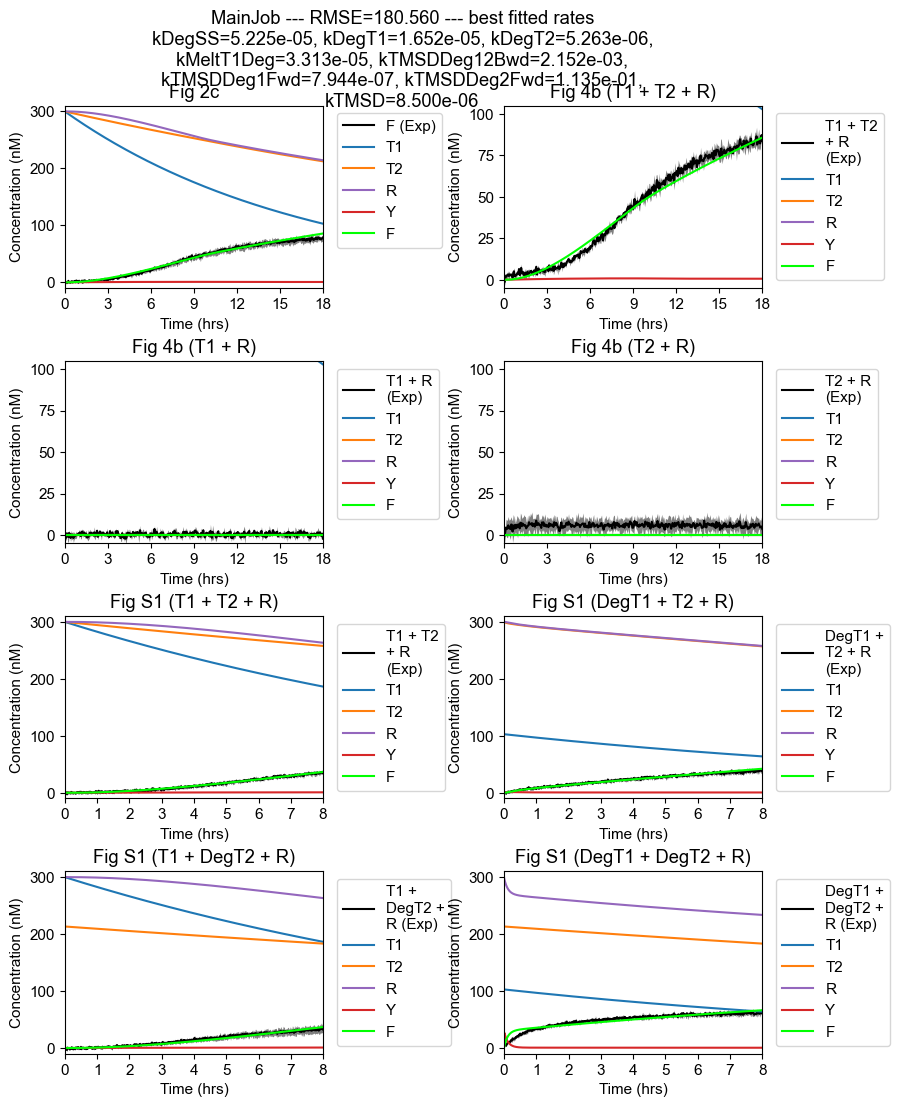

Best fitted rates: {'kDegSS': 5.2131785392140856e-05, 'kDegT1': 1.649937040931126e-05, 'kDegT2': 5.2499480986625425e-06, 'kMeltT1Deg': 3.2950271134857114e-05, 'kTMSDDeg12Bwd': 0.0094775265005726, 'kTMSDDeg1Fwd': 3.5311378533221185e-06, 'kTMSDDeg2Fwd': 11.717200213821197}
Best fitted RMSE: 180.19808715180153
Saved plot to FittingAnalysis_WideSweepJob_ComboTimecoursesPlot.pdf


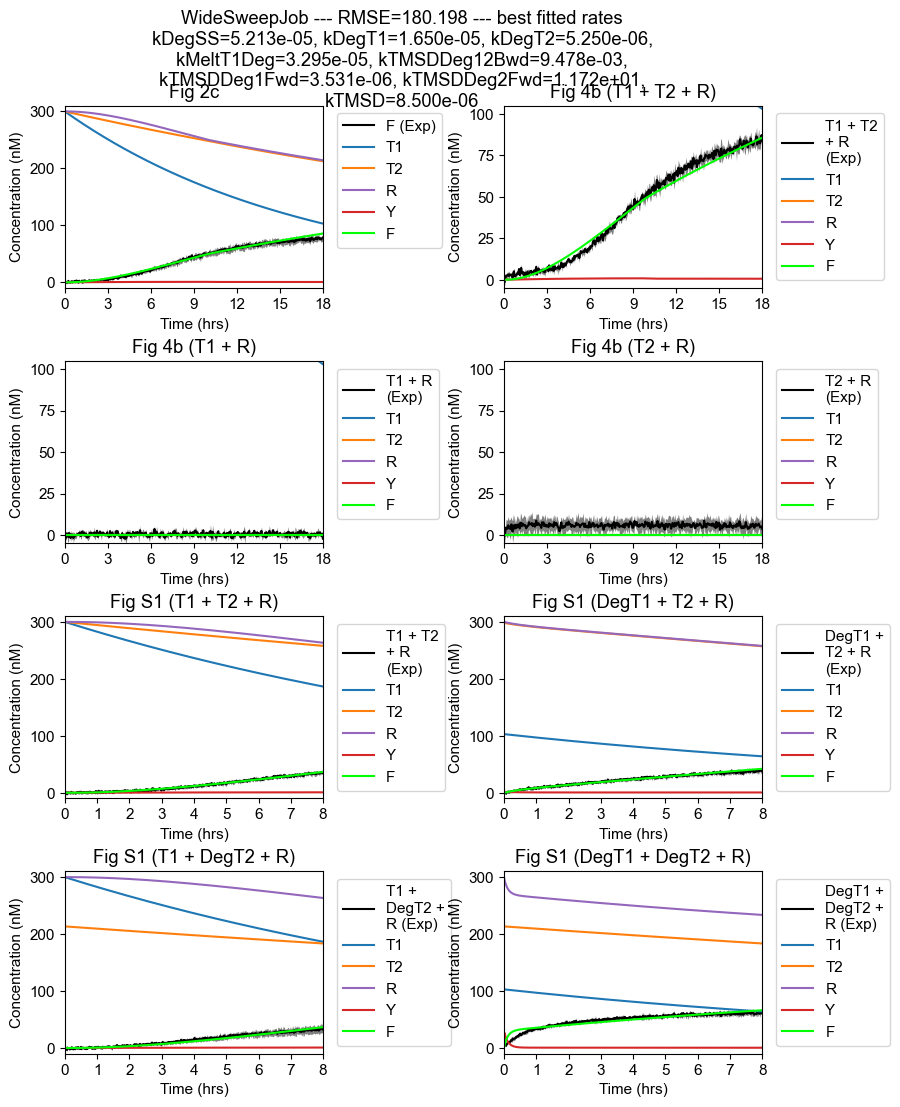

In [28]:
runAllPlottingJobs(sweepJobs, ['MainJob', 'WideSweepJob'], allData, sort=None, compact=True, outFilePrefix='FittingAnalysis')

## Rate constant vs RMSE plots, for all models

Saved plot to FittingAnalysis_MainJob_RateConstantsVsRMSEPlot_ColorFixed_AllPoints.pdf


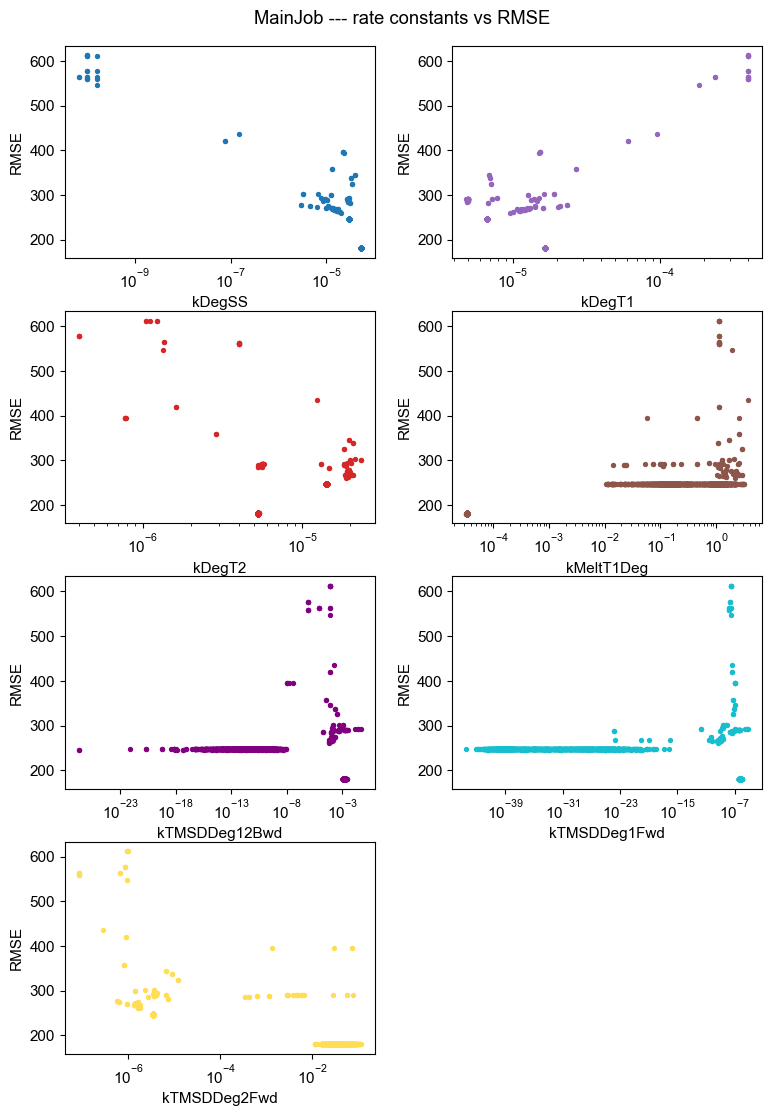

Saved plot to FittingAnalysis_WideSweepJob_RateConstantsVsRMSEPlot_ColorFixed_AllPoints.pdf


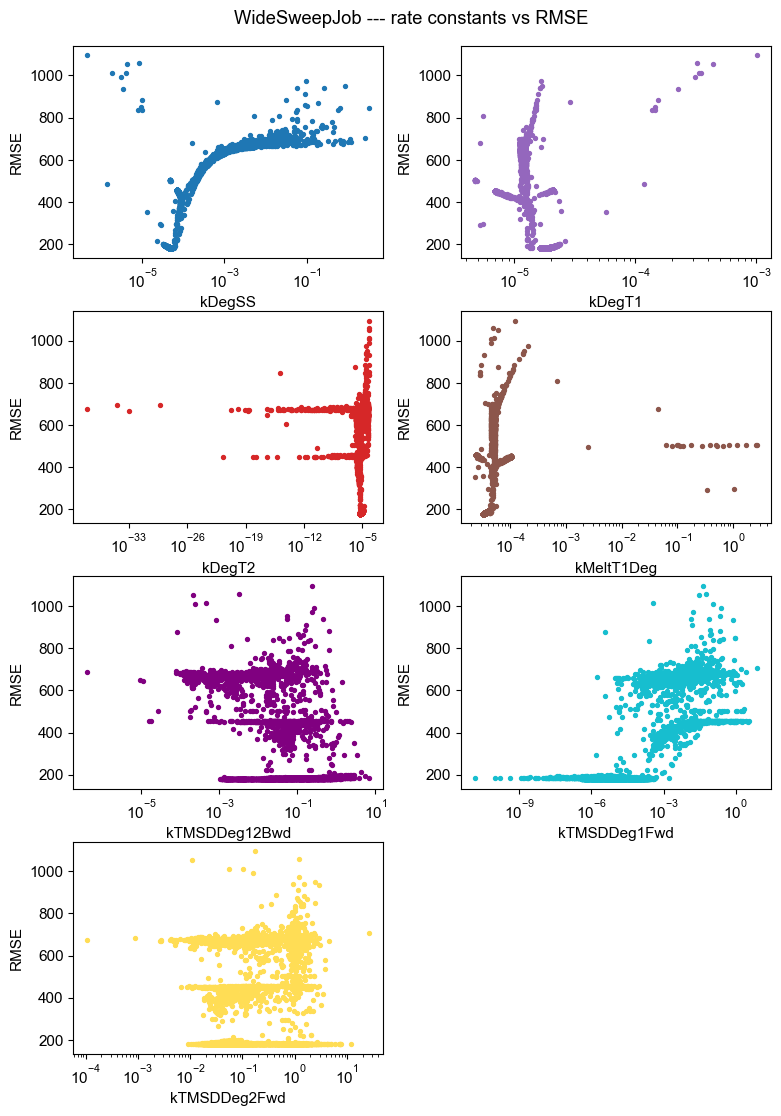

Saved plot to FittingAnalysis_MainJob_RateConstantsVsRMSEPlot_ColorLinearMap_AllPoints.pdf


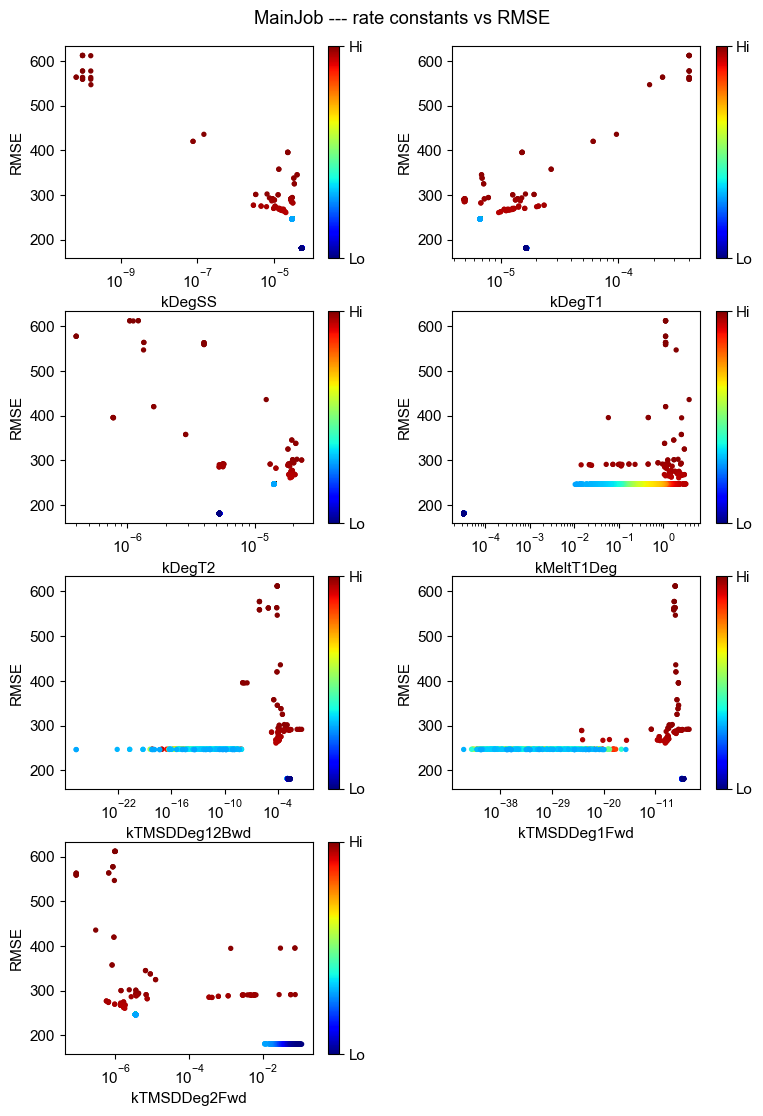

Saved plot to FittingAnalysis_WideSweepJob_RateConstantsVsRMSEPlot_ColorLinearMap_AllPoints.pdf


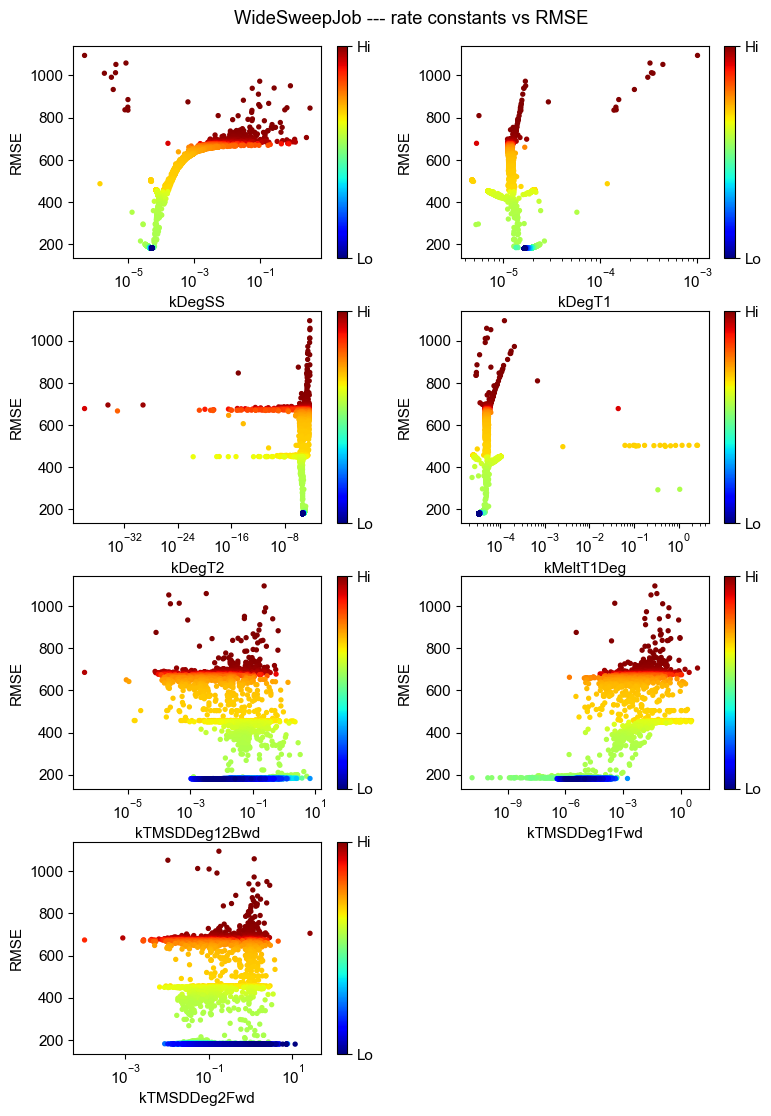

In [29]:
for colorsToUse in ['Fixed', 'LinearMap']:
    makeMultipleRateConstantPlots(sweepJobs, ['MainJob', 'WideSweepJob'], xscale='log', color=colorsToUse,
                                  maxRMSEs=None, showPlots=True, outFilePrefix=f'FittingAnalysis')

Saved plot to FittingAnalysis_WideSweepJob_RateConstantsVsRMSEPlot_ColorFixed_MaxRMSEsOnly.pdf


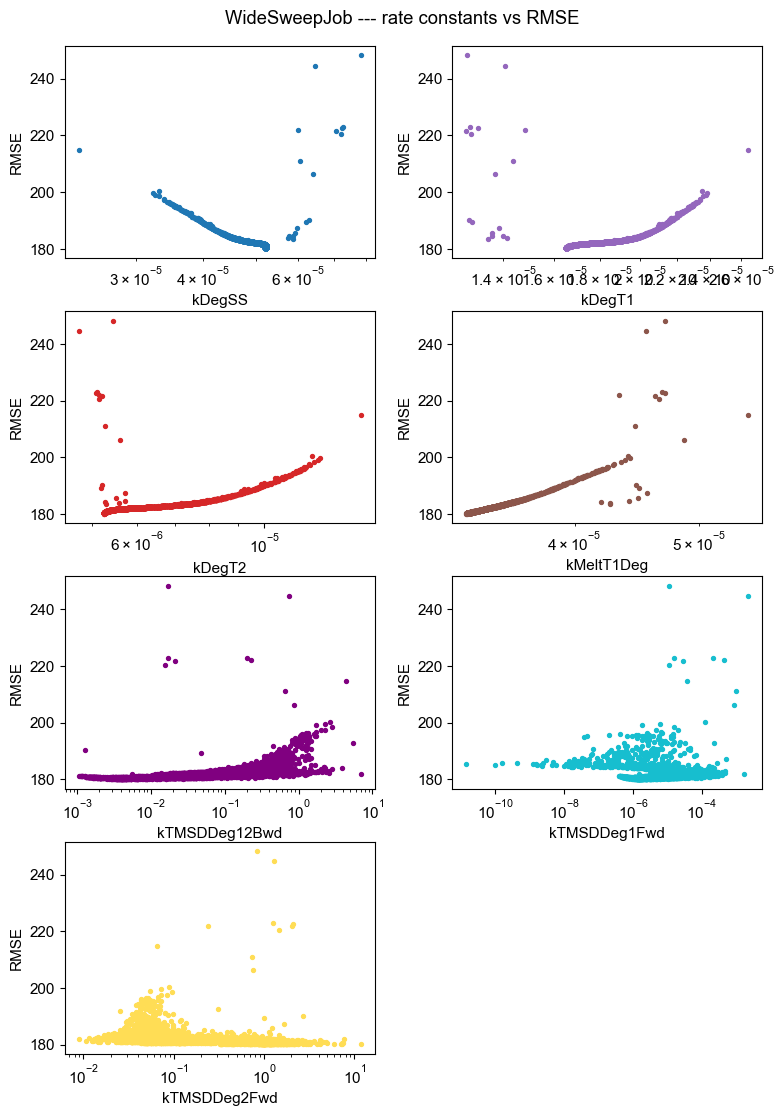

Saved plot to FittingAnalysis_WideSweepJob_RateConstantsVsRMSEPlot_ColorLinearMap_MaxRMSEsOnly.pdf


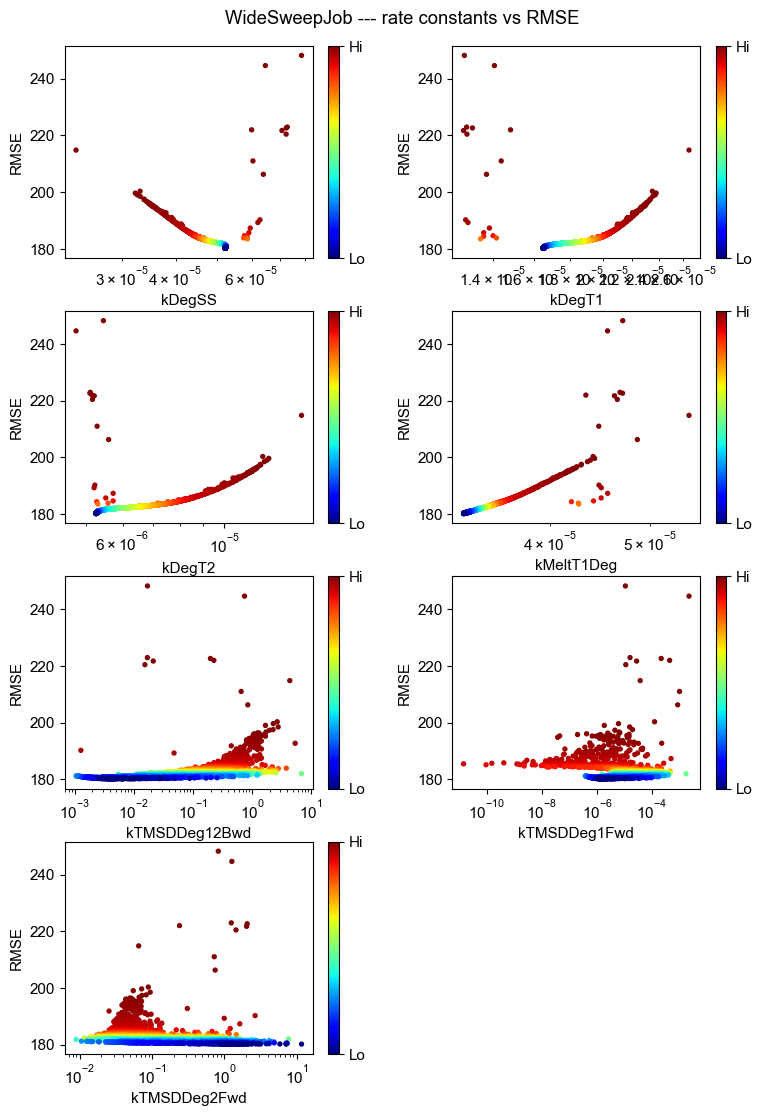

In [30]:
maxRMSEs = [250, 300, np.inf, 300, 300, 300, 300, 300, 275]
for colorsToUse in ['Fixed', 'LinearMap']:
    makeMultipleRateConstantPlots(sweepJobs, ['WideSweepJob'], color=colorsToUse, xscale='log',
                                  maxRMSEs=maxRMSEs, showPlots=True, outFilePrefix=f'FittingAnalysis')